# Hacemos los imports

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 100)
pd.set_option('max_columns', 60)

from scipy.stats import spearmanr, pearsonr

#Imports para los gráficos
import matplotlib.pylab as plt
#plt.rcParams['figure.figsize'] = [16, 8]
#plt.rcParams['figure.figsize'] = [8, 6]
import seaborn as sns
sns.set_style("darkgrid")

from time import process_time
from playsound import playsound
import json
from os import listdir

In [2]:
from funciones_metodos_v5 import calcular_funcion_modelo, calcular_funciones_base, fit_lineal, valor_funcion_costo, imprimirJson

from funciones_base_v3 import funcion_base_0, funcion_base_1

# Funciones

In [3]:
def graficar_distribucion(nombre_parametro, nombre_parametro_eje, fig_name, log_scale = False):
    
    dist = df_distribuciones[nombre_parametro].values
    sns.distplot(dist, hist = True, kde = False, norm_hist = False)
    plt.axvline(float(df_output.loc[nombre_parametro]["óptimo"]), linestyle = "--", lw = 1, label = "valor parámetro óptimo", color = "k")
    plt.xlabel(nombre_parametro_eje)
    plt.ylabel("cantidad de ocurrencias")
    if log_scale:
        plt.xscale("log")
    #plt.title("Ditribucion de los parametros optimos encontrados")
    plt.legend()
    plt.savefig(fig_name + ".jpg", dpi = 300)
    plt.show()

# Cargamos los datos experimentales

In [4]:
df_datos_experimentales = pd.read_csv("muestra93.txt", sep = " ", header = None)
df_datos_experimentales.columns = ["q", "intensidad"]

In [5]:
df_datos_experimentales.shape

(918, 2)

In [6]:
x_exp = df_datos_experimentales["q"]
y_exp = df_datos_experimentales["intensidad"] 

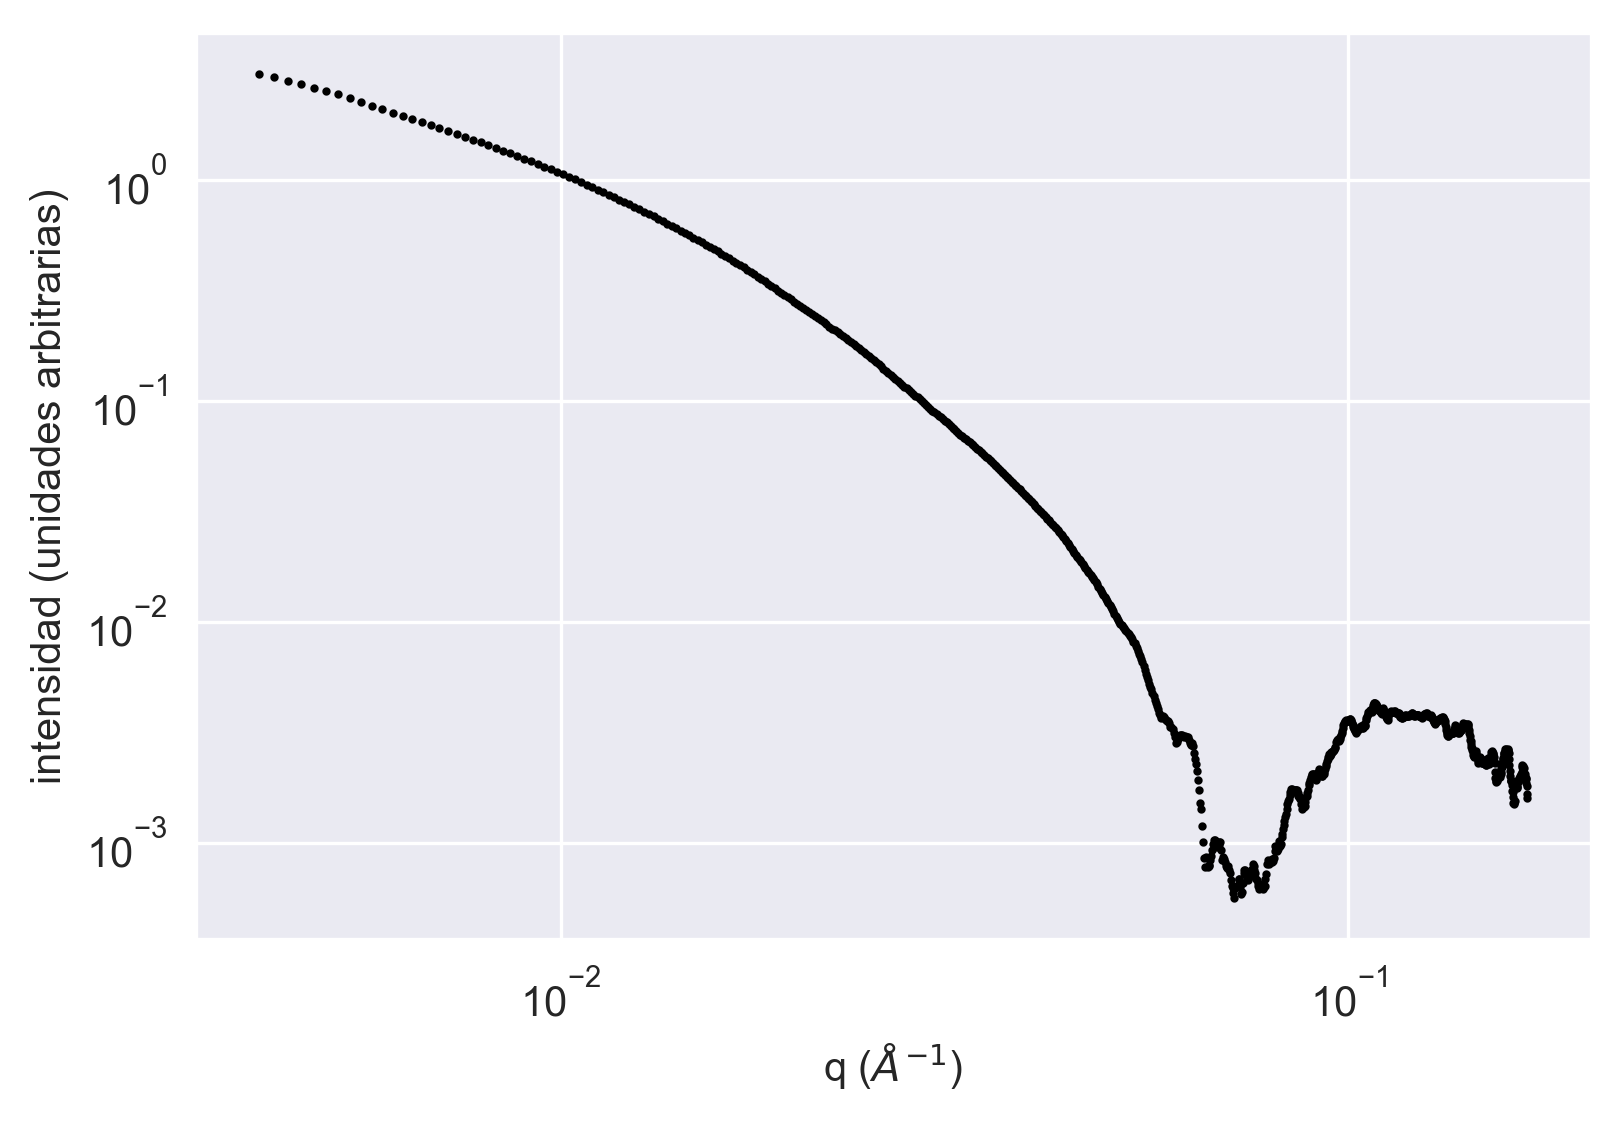

In [7]:
plt.figure(dpi = 300)
plt.plot(x_exp, y_exp, 'o', alpha=1, markersize=1, color="k")
plt.xscale("log")
plt.yscale("log")
plt.xlabel('q ($\AA^{-1}$)')
plt.ylabel('intensidad (unidades arbitrarias)')
#plt.title("Datos experimentales")
plt.savefig('Fig_1.jpg', dpi = 300)
plt.show()

Esta celda la usé para comparar algunos posibles $\sigma$

In [8]:
#plt.figure(dpi=300)
#plt.plot(x_exp, np.sqrt(y_exp), label = "sigma = sqrt(y_exp)")
#plt.plot(x_exp, y_exp * .1, label = "sigma = y_exp * .1")
#plt.xscale("log")
#plt.yscale("log")
#plt.xlabel("x_exp")
#plt.ylabel("sigma")
#plt.legend()
#plt.title("comparacion de sigmas")
#plt.savefig('comparacion de sigmas.png')
#plt.show()

# Definimos todo lo necesario para poder usar los modelos

#### Definimos sigma

In [9]:
#sigma = np.sqrt(y_exp)# * .1
sigma = y_exp * .1

#### Definimos las funciones base

In [10]:
funciones_base = [funcion_base_0, funcion_base_1]

#### Definimos los parámetros "originales"

In [11]:
# Tomamos como parámetros "originales" los encontrados por Cristián
c = .00000000001
p_lineales_original = np.array([.0001,c])
p_no_lineales_original = np.array([1.2 *10, 28 * 10, 2.96 * 10, 2.96 * 10, -4.7])

#### Definimos los rangos en los que se acota la búsqueda de cada parámetro

In [12]:
rangos_p_lineales = np.array([[0, .4]] * len(p_lineales_original)) #np.array([[-1.e-7, 1.e-7]] * len(p_lineales_original))
rangos_p_no_lineales = np.array([[5, 75], [5, 1500], [0,100], [0,100], [-10,10]])
#l = 5
#rangos_p_no_lineales = np.array([[p - np.abs(p) * l, p + np.abs(p) * l] for p in p_no_lineales_original])

In [13]:
rangos_p_lineales

array([[0. , 0.4],
       [0. , 0.4]])

In [14]:
rangos_p_no_lineales

array([[   5,   75],
       [   5, 1500],
       [   0,  100],
       [   0,  100],
       [ -10,   10]])

#### Esta variable sirve para setear la tolerancia en la ejecución de los modelos

In [15]:
valor_funcion_costo_original = 1

# Celdas para cargar los resultados guardados de los métodos

Setear datos_cargados en False si se quieren cargar los resultados de los métodos

In [16]:
datos_cargados = False

In [17]:
if datos_cargados == False:
    
    #lista de booleans, donde True quiere decir que se carga el info_debug del metodo correspondiente
    cargar_info_debug = [True, True, True, True, True, True, True, True, True, True, True, True]

    info_metodos = {}

    contador_metodo = 0
    for nombre_archivo in listdir('C:/Users/f.costa/Desktop/Modelos/aplicacion_metodos_v5/'):
        if nombre_archivo.startswith("metodo"):
            with open('C:/Users/f.costa/Desktop/Modelos/aplicacion_metodos_v5/' + nombre_archivo) as infile:

                input_json = json.load(infile)
                nombre_archivo = nombre_archivo[:-4]
                info_metodos[nombre_archivo] = {}

                metodo = input_json["metodo"] 
                iteraciones = input_json["max_iter"]
                reinicios = input_json["n_init"]
                tiempo_ejecucion = input_json["tiempo_ejecucion"]
                chi2_optimo = input_json["chi2_optimo"]
                p_l_optimo = np.array([parametro for parametro in input_json["p_l_optimo"]])
                p_no_l_optimo = np.array([parametro for parametro in input_json["p_no_l_optimo"]])
                array_p_optimo = np.concatenate( (p_l_optimo, p_no_l_optimo) )
                array_p_original = np.concatenate( (p_lineales_original, p_no_lineales_original) )
                p_lineales_incial = np.array(input_json["info_debug"][0][1])
                p_no_lineales_incial = np.array(input_json["info_debug"][0][0])
                parametros_inciales = np.concatenate( (p_lineales_incial, p_no_lineales_incial) )
                chi2_inicial = input_json["info_debug"][0][2]

                norm_2 = np.linalg.norm(np.subtract(array_p_optimo, array_p_original))
                norm_prop = sum([ np.abs(array_p_optimo[i] - array_p_original[i]) / np.abs(array_p_original[i]) for i in range(len(array_p_original)) ])

                info_metodos[nombre_archivo]["metodo"] = metodo
                info_metodos[nombre_archivo]["max_iter"] = iteraciones
                info_metodos[nombre_archivo]["n_init"] = reinicios
                info_metodos[nombre_archivo]["tiempo_ejecucion"] = tiempo_ejecucion
                info_metodos[nombre_archivo]["chi2_optimo"] = chi2_optimo
                info_metodos[nombre_archivo]["p_l_optimo"] = p_l_optimo
                info_metodos[nombre_archivo]["p_no_l_optimo"] = p_no_l_optimo
                info_metodos[nombre_archivo]["array_p_optimo"] = array_p_optimo
                info_metodos[nombre_archivo]["array_p_original"] = array_p_original
                info_metodos[nombre_archivo]["norm_2"] = norm_2
                info_metodos[nombre_archivo]["norm_prop"] = norm_prop
                info_metodos[nombre_archivo]["info_debug_inicializaciones"] = input_json["info_debug_inicializaciones"]
                info_metodos[nombre_archivo]["parametros_iniciales"] = parametros_inciales
                info_metodos[nombre_archivo]["chi2_inicial"] = chi2_inicial
                if cargar_info_debug[contador_metodo]:
                    info_metodos[nombre_archivo]["info_debug"] = input_json["info_debug"]

            contador_metodo = contador_metodo + 1
            input_json = None

            infile.close()     
            print(nombre_archivo, "cargado.")  

    datos_cargados = True

metodo_1-1000_200 cargado.
metodo_1_1-1000_200 cargado.
metodo_2-0_40 cargado.
metodo_3-1000_200 cargado.


# Comparación y análisis de los métodos

#### Creamos un dataframe con un resumen de los resultados de los métodos ejecutados

In [18]:
if datos_cargados:

    l_metodo , l_iteraciones, l_reinicios, l_tiempo_ejecucion, l_chi2_optimo = [], [], [], [], []
    l_array_p_optimo , l_array_p_original, l_norm_2 = [], [], []
    l_parametros_iniciales, l_chi2_inicial = [], []

    for item in info_metodos.keys():
        
        metodo = info_metodos[item]["metodo"]
        iteraciones = info_metodos[item]["max_iter"]
        reinicios = info_metodos[item]["n_init"]
        tiempo_ejecucion = info_metodos[item]["tiempo_ejecucion"]
        chi2_optimo = info_metodos[item]["chi2_optimo"]
        p_l_optimo = [parametro for parametro in info_metodos[item]["p_l_optimo"]]
        p_no_l_optimo = [parametro for parametro in info_metodos[item]["p_no_l_optimo"]]
        array_p_optimo = np.concatenate( (p_l_optimo, p_no_l_optimo) )
        array_p_original = np.concatenate( (p_lineales_original, p_no_lineales_original) )
        parametros_inciales = info_metodos[item]['parametros_iniciales']
        chi2_inicial = info_metodos[item]['chi2_inicial']

        norm_2 = np.linalg.norm(np.subtract(array_p_optimo, array_p_original))
        norm_prop = sum([ np.abs(array_p_optimo[i] - array_p_original[i]) / np.abs(array_p_original[i]) for i in range(len(array_p_original)) ])
        
        l_metodo.append(metodo)
        l_iteraciones.append(iteraciones)
        l_reinicios.append(reinicios)
        l_tiempo_ejecucion.append(int(tiempo_ejecucion))
        l_chi2_optimo.append('{:.3e}'.format(chi2_optimo))
        l_array_p_optimo.append(array_p_optimo)
        l_array_p_original.append(array_p_original)
        l_norm_2.append(norm_2)
        l_parametros_iniciales.append(parametros_inciales)
        l_chi2_inicial.append('{:.3e}'.format(chi2_inicial))
    
    df = pd.DataFrame({"metodo":l_metodo, "iteraciones": l_iteraciones, "reinicios": l_reinicios,
                       "chi2_optimo": l_chi2_optimo, "chi2_inicial": l_chi2_inicial, "norm_2": l_norm_2, 
                       "tiempo_ejecucion(segundos)": l_tiempo_ejecucion,
                       "parametros_optimos": l_array_p_optimo, "parametros_inciales":l_parametros_iniciales,
                       "parametros_originales": l_array_p_original
                      })
    df.sort_values('chi2_optimo', inplace = True, ascending = True) 

#### Resumen del resultado de los métodos

Figura 2

In [19]:
columnas = ["metodo", "reinicios", "iteraciones", "chi2_optimo", "chi2_inicial", "tiempo_ejecucion(segundos)"]
#columnas = ["metodo", "reinicios", "iteraciones", "chi2_optimo", "chi2_inicial"]
df[columnas].sort_values("metodo")
#df.sort_values("chi2_optimo")

,metodo,reinicios,iteraciones,chi2_optimo,chi2_inicial,tiempo_ejecucion(segundos)
0,metodo_1,200,1000,8.716e+12,6.515e+25,960
1,metodo_1_1,200,1000,2.825e+00,2.931e+01,982
2,metodo_2,40,0,2.107e+00,4.034e+21,1144
3,metodo_3,200,1000,1.510e+00,4.825e+01,607


#### Armamos un dataframe con los datos de cada una de las inicializaciones de cada método

In [20]:
if datos_cargados:

    l_metodo , l_iteraciones, l_reinicios, l_tiempo_ejecucion, l_chi2_optimo = [], [], [], [], []
    l_array_p_optimo , l_array_p_original, l_norm_2 = [], [], []
    l_init = []
    l_array_p_inicial, l_chi2_incial = [], []

    for item in info_metodos.keys():
        
        metodo = info_metodos[item]["metodo"]
        iteraciones = info_metodos[item]["max_iter"]
        reinicios = info_metodos[item]["n_init"]
        tiempo_ejecucion = info_metodos[item]["tiempo_ejecucion"]
        
        for init in range(reinicios):
            
            resultados = info_metodos[item]["info_debug_inicializaciones"][init][1]
            valores_iniciales = info_metodos[item]["info_debug_inicializaciones"][init][0]
            chi2_optimo = resultados[2]
            chi2_inicial = valores_iniciales[2]
            p_l_optimo = np.array([parametro for parametro in resultados[1]])
            p_no_l_optimo = np.array([parametro for parametro in resultados[0]])
            array_p_optimo = np.concatenate( (np.array(p_l_optimo), np.array(p_no_l_optimo)) )
            array_p_original = np.concatenate( (np.array(p_lineales_original), np.array(p_no_lineales_original)) )
            p_l_inicial = np.array([parametro for parametro in valores_iniciales[1]])
            p_no_l_inicial = np.array([parametro for parametro in valores_iniciales[0]])
            array_p_inicial = np.concatenate( (p_l_inicial, p_no_l_inicial) )

            norm_2 = np.linalg.norm(np.subtract(array_p_optimo, array_p_original))
            norm_prop = sum([ np.abs(array_p_optimo[i] - array_p_original[i]) / np.abs(array_p_original[i]) for i in range(len(array_p_original)) ])
            
            l_init.append(init)
            l_metodo.append(metodo)
            l_iteraciones.append(iteraciones)
            l_reinicios.append(reinicios)
            l_tiempo_ejecucion.append(tiempo_ejecucion)
            l_chi2_optimo.append(chi2_optimo)
            l_array_p_optimo.append(array_p_optimo)
            l_array_p_original.append(array_p_original)
            l_norm_2.append(norm_2)
            l_array_p_inicial.append(array_p_inicial)
            l_chi2_incial.append(chi2_inicial)
    
    df_2 = pd.DataFrame({"metodo":l_metodo, "iteraciones": l_iteraciones, "reinicios": l_reinicios,
                       "numero_inicializacion": l_init,
                       "chi2_optimo": l_chi2_optimo, "chi2_inicial": l_chi2_incial, "norm_2": l_norm_2, 
                       "tiempo_ejecucion": l_tiempo_ejecucion,
                       "parametros_optimos": l_array_p_optimo, "parametros_iniciales": l_array_p_inicial, 
                       "parametros_originales": l_array_p_original
                      })
    
    df_2.sort_values('chi2_optimo', inplace = True, ascending = True) 

#### Información de todos los métodos en cada inicialización

In [21]:
columnas = ["metodo", "reinicios", "iteraciones", "chi2_optimo", "chi2_inicial", "numero_inicializacion"]
df_2[columnas].sort_values(["chi2_optimo"])
#df_2[df_2["metodo"] == "metodo_2"][columnas].sort_values("numero_inicializacion")

,metodo,reinicios,iteraciones,chi2_optimo,chi2_inicial,numero_inicializacion
523,metodo_3,200,1000,1.510084e+00,4.824808e+01,83
594,metodo_3,200,1000,1.615692e+00,4.585989e+01,154
578,metodo_3,200,1000,1.635643e+00,5.118682e+01,138
564,metodo_3,200,1000,1.663256e+00,5.139331e+01,124
576,metodo_3,200,1000,1.811999e+00,1.375404e+01,136
610,metodo_3,200,1000,1.822422e+00,4.669842e+01,170
599,metodo_3,200,1000,1.880155e+00,4.220395e+01,159
474,metodo_3,200,1000,1.884839e+00,3.905176e+01,34
441,metodo_3,200,1000,1.921775e+00,4.892535e+01,1
509,metodo_3,200,1000,1.985054e+00,3.255264e+01,69


#### Podemos ver la distribución de los $\chi^2$ iniciales para entender cómo comienza cada inicialización (sobre todo para ver qué tan frío empieza el sistema para el simulated annealing)

In [22]:
#df_2[df_2["metodo"] == "metodo_3"]["chi2_inicial"].describe()

In [23]:
#sns.distplot(df_2[df_2["metodo"] == "metodo_3"]["chi2_inicial"], kde = False)
#plt.show()

#sns.distplot(df_2[df_2["metodo"] == "metodo_1"]["chi2_inicial"], kde = False)
#plt.show()

## Análisis de las iteraciones: metodo_1 vs metodo_1_1 vs metodo_3.

In [24]:
metodo_a_comparar_1 = "metodo_1-1000_200"
metodo_a_comparar_2 = "metodo_1_1-1000_200"
metodo_a_comparar_3 = "metodo_3-1000_200"

#### Gráfico del comportamiento del valor de la figura de mérito

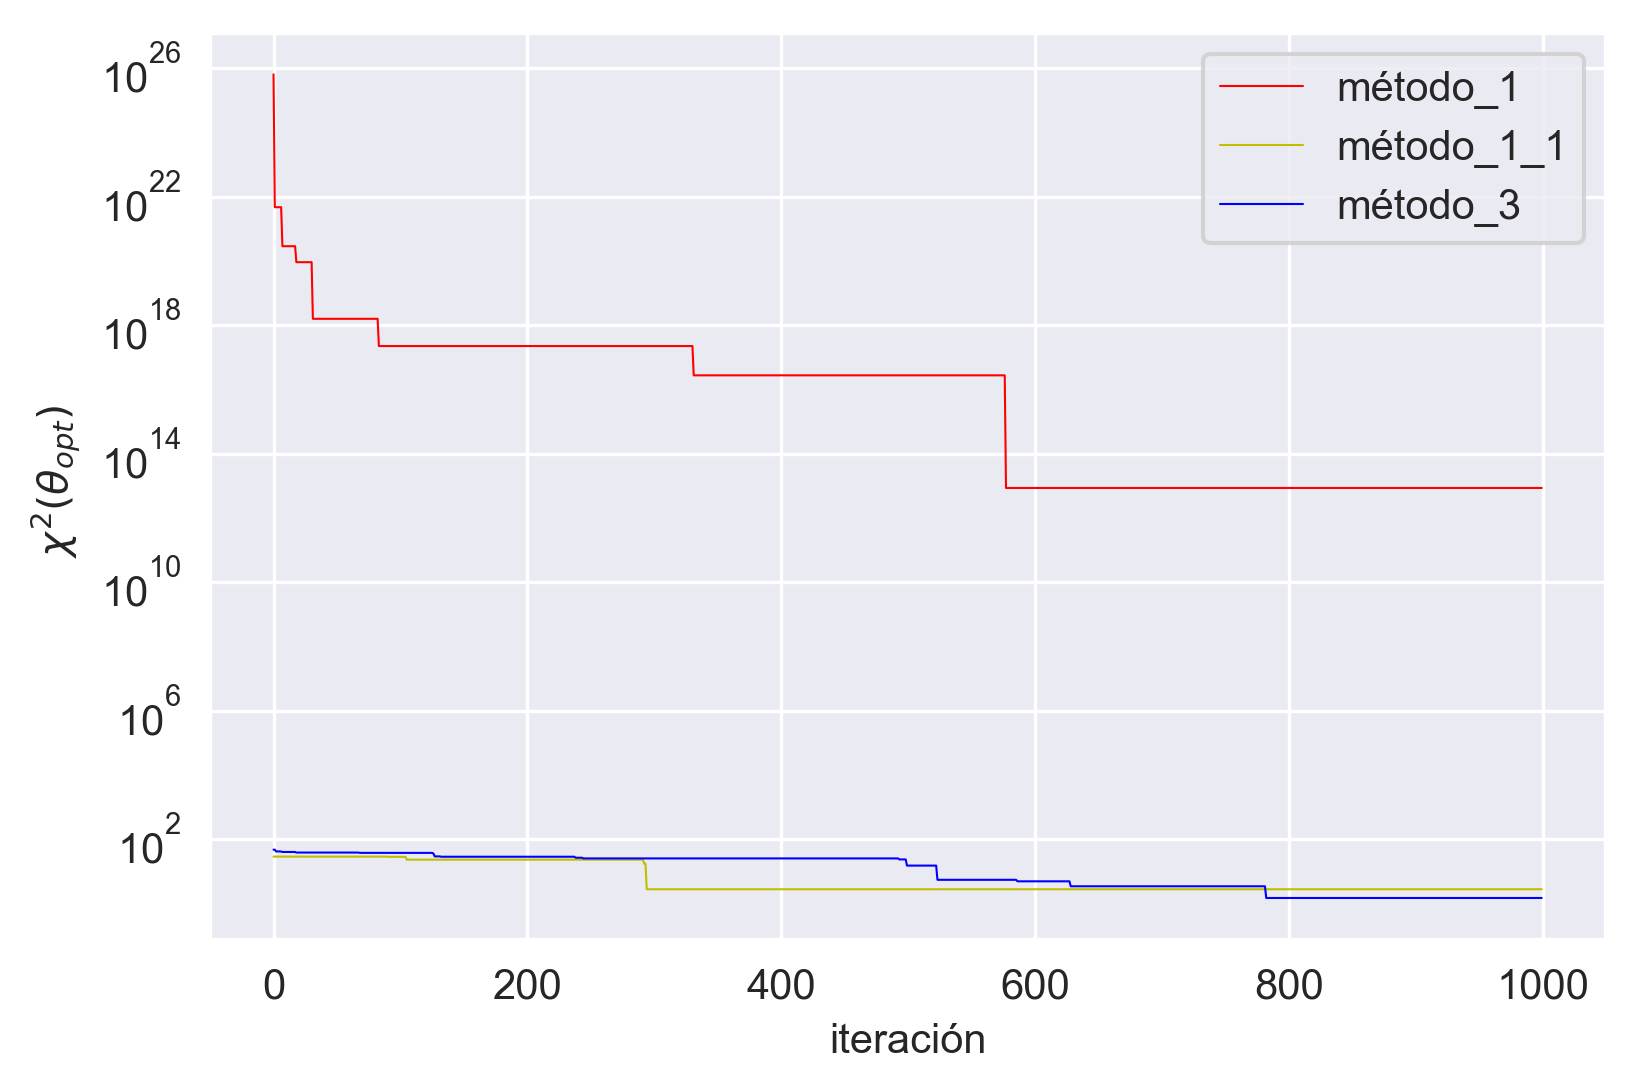

<Figure size 432x288 with 0 Axes>

In [25]:
plt.figure(dpi=300)

chi2_metodo_1 = [item[2] for item in info_metodos[metodo_a_comparar_1]["info_debug"]]
chi2_metodo_2 = [item[2] for item in info_metodos[metodo_a_comparar_2]["info_debug"]]
chi2_metodo_3 = [item[2] for item in info_metodos[metodo_a_comparar_3]["info_debug"]]

plt.plot(range(len(chi2_metodo_1)), chi2_metodo_1, '-', lw = .5, color="r", label = "método_1")
plt.plot(range(len(chi2_metodo_2)), chi2_metodo_2, '-', lw = .5, color="y", label = "método_1_1")
plt.plot(range(len(chi2_metodo_3)), chi2_metodo_3, '-', lw = .5, color="b", label = "método_3")

plt.yscale('log')
#extraticks = [0.1, 1, 5]
#plt.yticks(list(plt.yticks()[0]) + extraticks)
#plt.ylim([0, 100])
plt.xlabel('iteración')
plt.ylabel(r' $\chi^2(\theta _{opt})$')
#plt.title(r"Comportamiento de $\chi^2(\theta _{opt})$")
plt.legend()
plt.savefig("Fig_3.jpg", dpi = 300)
plt.show()

#limpiamos las variables para no ocupar memoria
chi2_metodo_1, chi2_metodo_1, chi2_metodo_3 = [], [], []
plt.clf()

Método 1_1: el primer valor menor o igual que 10 se da en la iteración: 294
Método 1_1: el primer valor menor o igual que 1.9 se da en la iteración: 0
Método 3: el primer valor menor o igual que 10 se da en la iteración: 523
Método 3: el primer valor menor o igual que 1.9 se da en la iteración: 782


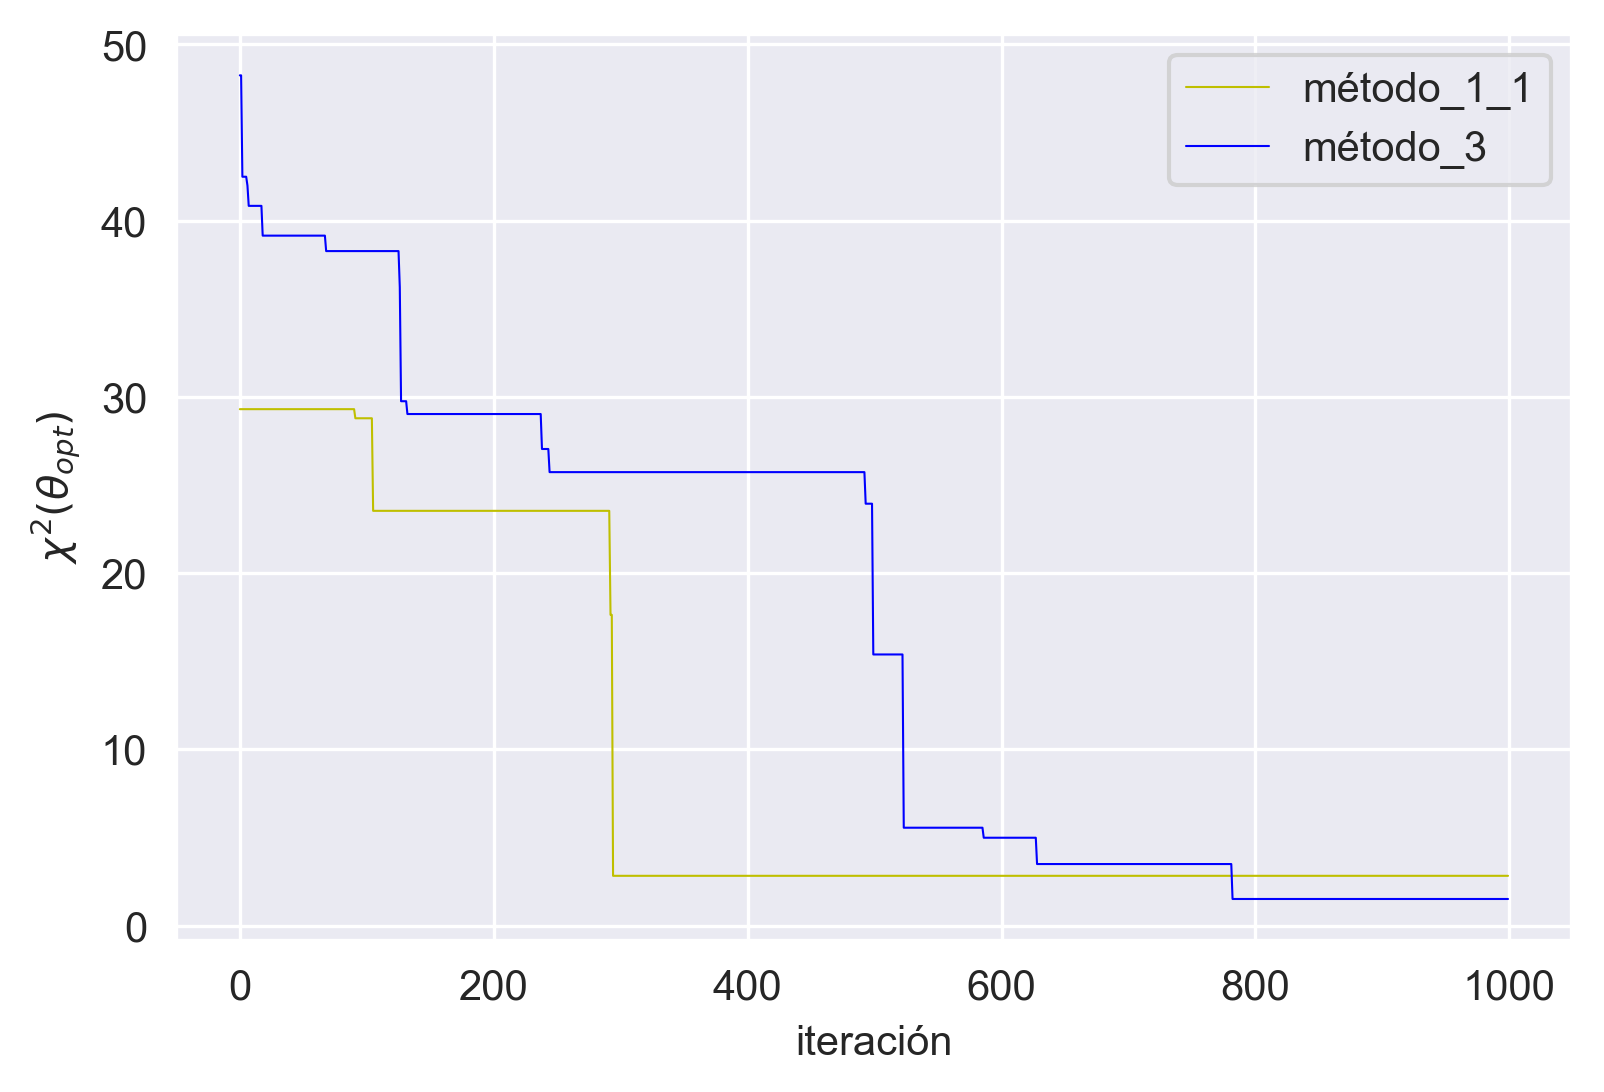

<Figure size 432x288 with 0 Axes>

In [26]:
plt.figure(dpi=300)

#chi2_metodo_1 = [item[2] for item in info_metodos[metodo_a_comparar_1]["info_debug"]]
chi2_metodo_2 = [item[2] for item in info_metodos[metodo_a_comparar_2]["info_debug"]]
chi2_metodo_3 = [item[2] for item in info_metodos[metodo_a_comparar_3]["info_debug"]]

#plt.plot(range(len(chi2_metodo_1)), chi2_metodo_1, '-', lw = .5, color="r", label = "método_1")
plt.plot(range(len(chi2_metodo_2)), chi2_metodo_2, '-', lw = .5, color="y", label = "método_1_1")
plt.plot(range(len(chi2_metodo_3)), chi2_metodo_3, '-', lw = .5, color="b", label = "método_3")

iteracion_buscada=0
contador = 0
for x in chi2_metodo_2:
    if x <= 10:
        iteracion_buscada = contador
        break
    contador = contador + 1
print("Método 1_1: el primer valor menor o igual que 10 se da en la iteración:", iteracion_buscada)

iteracion_buscada=0
contador = 0
for x in chi2_metodo_2:
    if x <= 1.9:
        iteracion_buscada = contador
        break
    contador = contador + 1
print("Método 1_1: el primer valor menor o igual que 1.9 se da en la iteración:", iteracion_buscada)

iteracion_buscada=0
contador = 0
for x in chi2_metodo_3:
    if x <= 10:
        iteracion_buscada = contador
        break
    contador = contador + 1
print("Método 3: el primer valor menor o igual que 10 se da en la iteración:", iteracion_buscada)

iteracion_buscada=0
contador = 0
for x in chi2_metodo_3:
    if x <= 1.9:
        iteracion_buscada = contador
        break
    contador = contador + 1
print("Método 3: el primer valor menor o igual que 1.9 se da en la iteración:", iteracion_buscada)


#plt.yscale('log')
#extraticks = [1]
#plt.yticks(list(plt.yticks()[0]) + extraticks)
#plt.ylim([0, 100])
#plt.axhline(1, linestyle = "--", lw= .5, color = "k")
plt.xlabel('iteración')
plt.ylabel(r'$\chi^2(\theta _{opt})$')
#plt.title(r"Comportamiento de $\chi^2(\theta _{opt})$")
plt.legend()
plt.savefig("Fig_4.jpg", dpi = 300)
plt.show()

#limpiamos las variables para no ocupar memoria
chi2_metodo_1, chi2_metodo_1, chi2_metodo_3 = [], [], []
plt.clf()

En el gráfico anterior se puede ver que el método 1 pierde por mucho contra los otros dos métodos. La razón es que busca TODOS los parámetros al azar, mientras que los otros dos métodos buscan sólo los parámetros no lineales y luego fitean los lineales.

#### Gráfico de la "búsqueda" de los parámetros lineales

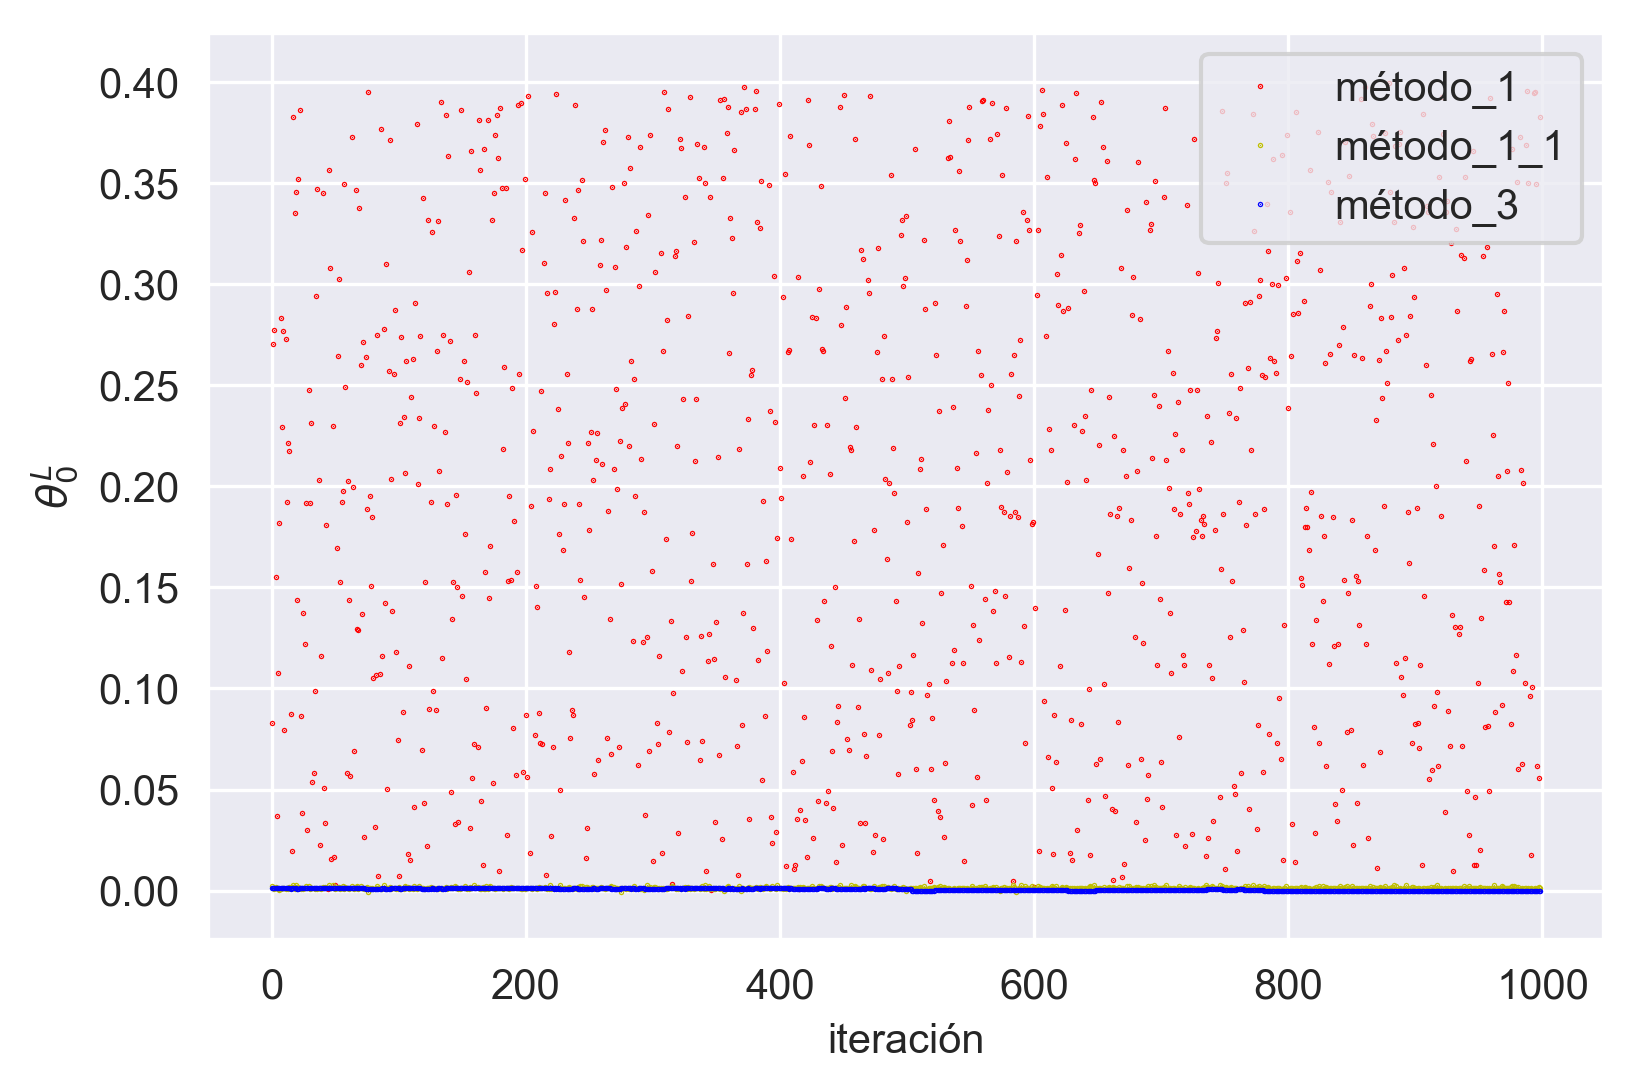

In [27]:
plt.figure(dpi=300)
num_p_l = 0

p_lineal_metodo_1 = [item[4][num_p_l] for item in info_metodos[metodo_a_comparar_1]["info_debug"]][1:]
p_lineal_metodo_2 = [item[4][num_p_l] for item in info_metodos[metodo_a_comparar_2]["info_debug"]][1:]
p_lineal_metodo_3 = [item[4][num_p_l] for item in info_metodos[metodo_a_comparar_3]["info_debug"]][1:]

plt.plot(range(len(p_lineal_metodo_1)), p_lineal_metodo_1, 'o', alpha=1, markersize=.3, color="r", lw=.1, label = "método_1")
plt.plot(range(len(p_lineal_metodo_2)), p_lineal_metodo_2, 'o', alpha=1, markersize=.3, color="y", lw=.1, label = "método_1_1")
plt.plot(range(len(p_lineal_metodo_3)), p_lineal_metodo_3, 'o', alpha=1, markersize=.3, color="b", lw=.1, label = "método_3")

long_rango = np.abs(rangos_p_lineales[num_p_l][1] - rangos_p_lineales[num_p_l][0])
plt.ylim(rangos_p_lineales[num_p_l] + np.multiply( (-1,1), long_rango * .06))
#plt.axhline(rangos_p_lineales[num_p_l][0], linestyle="--", color = "g", label = "limite_rango")
#plt.axhline(rangos_p_lineales[num_p_l][1], linestyle="--", color = "g", label = "limite_rango")
#plt.axhline(p_lineales_original[num_p_l], linestyle='--', color="k", lw=.5, label = "p lineal original")
plt.xlabel('iteración')
plt.ylabel(r'$\theta^L_0$')
#plt.title(r'Búsqueda de $\theta^L_0$')
plt.legend(loc="upper right")
plt.savefig("Fig_5.jpg", dpi=300)
plt.show()

#limpiamos las variables para no ocupar memoria
p_lineal_metodo_1, p_lineal_metodo_2, p_lineal_metodo_3 = [], [], []

#### Gráfico de la "búsqueda" de los parámetros no lineales

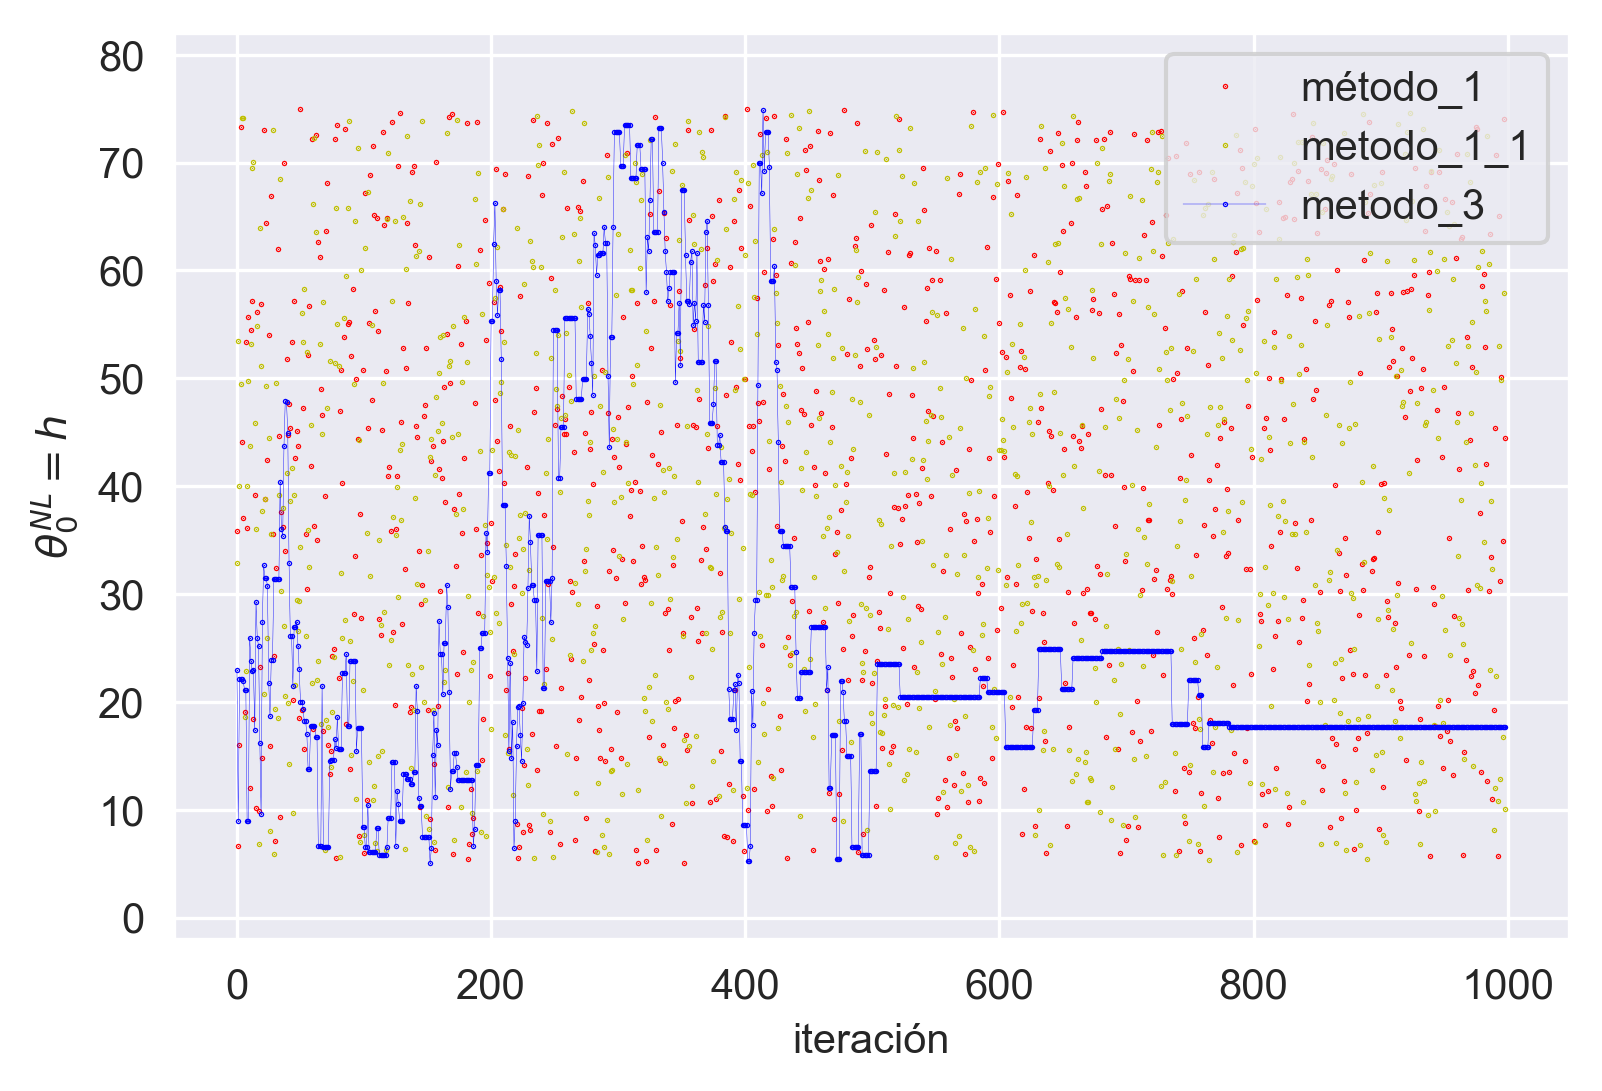

<Figure size 432x288 with 0 Axes>

In [28]:
plt.figure(dpi=300)

num_p_no_l = 0

p_no_lineal_metodo_1 = [item[3][num_p_no_l] for item in info_metodos[metodo_a_comparar_1]["info_debug"]][1:]
p_no_lineal_metodo_2 = [item[3][num_p_no_l] for item in info_metodos[metodo_a_comparar_2]["info_debug"]][1:]
p_no_lineal_metodo_3 = [item[3][num_p_no_l] for item in info_metodos[metodo_a_comparar_3]["info_debug"]][1:]

plt.plot(range(len(p_no_lineal_metodo_1)), p_no_lineal_metodo_1, 'o', alpha=1, markersize=.3, color="r", lw=.2, label = "método_1")
plt.plot(range(len(p_no_lineal_metodo_2)), p_no_lineal_metodo_2, 'o', alpha=1, markersize=.3, color="y", lw=.2, label = "metodo_1_1")
plt.plot(range(len(p_no_lineal_metodo_3)), p_no_lineal_metodo_3, '-o', alpha=1, markersize=.3, color="b", lw=.1, label = "metodo_3")

long_rango = np.abs(rangos_p_no_lineales[num_p_no_l][1] - rangos_p_no_lineales[num_p_no_l][0])
plt.ylim(rangos_p_no_lineales[num_p_no_l] + np.multiply( (-1,1), long_rango * .1))
#plt.axhline(rangos_p_no_lineales[num_p_no_l][0], linestyle="--", color = "g", label = "limite_rango")
#plt.axhline(rangos_p_no_lineales[num_p_no_l][1], linestyle="--", color = "g", label = "limite_rango")
#plt.axhline(p_no_lineales_original[num_p_no_l], linestyle='--', color="k", lw=.5, label = "p no lineal original")
plt.xlabel('iteración')
plt.ylabel(r'$\theta^{NL}_0=h$')
#plt.title(r"Búsqueda de $\theta^{NL}_0$")
plt.legend(loc="upper right")
plt.savefig("Fig_6.jpg", dpi=300)
plt.show()

#limpiamos las variables para no ocupar memoria
p_no_lineal_metodo_1, p_no_lineal_metodo_2, p_no_lineal_metodo_3 = [], [], []
plt.clf()

## Obtenemos el output del método 3

In [29]:
metodo = "metodo_3-1000_200"

In [30]:
nombre_metodo = metodo.split("-")[0]
iteraciones = int((metodo.split("-")[1]).split("_")[0])
reinicios = int((metodo.split("-")[1]).split("_")[1])

n_inicializacion = 0
info_inicializacion = info_metodos[metodo]["info_debug_inicializaciones"][n_inicializacion]
final = info_inicializacion[1]
p_no_l_final = final[0]
p_l_final = final[1]
cant_p_lineales = len(p_l_final)
cant_p_no_lineales = len(p_no_l_final)

filter_metodo = (df_2["metodo"] ==  nombre_metodo) & (df_2["iteraciones"] == iteraciones) & (df_2["reinicios"] == reinicios)
df_parametros_optimos = (df_2[filter_metodo][["numero_inicializacion", "parametros_optimos", "chi2_optimo"]])
df_parametros_optimos.sort_values("numero_inicializacion", inplace = True)
m = np.array(list(df_parametros_optimos["parametros_optimos"]))
m_t = m.transpose()
m_t.shape

df_distribuciones = pd.DataFrame(index = df_parametros_optimos["numero_inicializacion"].values)
df_distribuciones.index.name='numero_inicializacion'
for num_p_l in range(cant_p_lineales):
    df_distribuciones["p_l_" + str(num_p_l)] = m_t[num_p_l]
for num_p_no_l in range(cant_p_no_lineales):
    df_distribuciones["p_no_l_" + str(num_p_no_l)] = m_t[cant_p_lineales + num_p_no_l]
    
mejores_parametros_optimos = df_parametros_optimos.sort_values("chi2_optimo", ascending = True).iloc[0]["parametros_optimos"]
numero_mejor_reinicio = df_parametros_optimos.sort_values("chi2_optimo", ascending = True).iloc[0]["numero_inicializacion"]

lista_nombres_parametros = []
for num_p_l in range(cant_p_lineales):
    lista_nombres_parametros.append("p_l_" + str(num_p_l))
for num_p_no_l in range(cant_p_no_lineales):
    lista_nombres_parametros.append("p_no_l_" + str(num_p_no_l))

df_output = pd.DataFrame(index = lista_nombres_parametros)
df_output["óptimo"] = ['{:.3e}'.format(p_opt) for p_opt in mejores_parametros_optimos]
estadisticos = df_distribuciones.describe()
df_output["desviación_estándar"] = ['{:.3e}'.format(estadisticos[nombre_p]["std"]) for nombre_p in lista_nombres_parametros]
df_output["media"] = ['{:.3e}'.format(estadisticos[nombre_p]["mean"]) for nombre_p in lista_nombres_parametros]
df_output["mediana"] = ['{:.3e}'.format(estadisticos[nombre_p]["50%"]) for nombre_p in lista_nombres_parametros]
df_output["mínimo"] = ['{:.3e}'.format(estadisticos[nombre_p]["min"]) for nombre_p in lista_nombres_parametros]
df_output["máximo"] = ['{:.3e}'.format(estadisticos[nombre_p]["max"]) for nombre_p in lista_nombres_parametros]
df_output["cantidad"] = ['{:.3e}'.format(estadisticos[nombre_p]["count"]) for nombre_p in lista_nombres_parametros]

#### Estadísticos de interés

Figura 7

In [31]:
df_output["nombre"] = [r'$\theta^L_0$', r'$\theta^L_1$', r'$h$', r'$w$', r'$t_h$', r'$t_w$', r'$\beta$']
columnas_de_interes = ["nombre", "óptimo", "desviación_estándar", "mediana", "mínimo", "máximo"]
df_output[columnas_de_interes]

,nombre,óptimo,desviación_estándar,mediana,mínimo,máximo
p_l_0,$\theta^L_0$,3.739e-05,3.305e-04,6.535e-04,3.440e-06,1.186e-03
p_l_1,$\theta^L_1$,8.954e-12,2.023e-10,5.428e-12,6.155e-13,2.068e-09
p_no_l_0,$h$,1.765e+01,9.253e+00,1.763e+01,5.241e+00,6.896e+01
p_no_l_1,$w$,1.801e+02,4.076e+02,4.585e+02,1.850e+01,1.406e+03
p_no_l_2,$t_h$,2.399e+01,5.511e+00,2.321e+01,6.613e+00,3.692e+01
p_no_l_3,$t_w$,3.800e+01,2.206e+01,3.792e+01,6.307e-01,9.890e+01
p_no_l_4,$\beta$,-7.152e+00,6.217e+00,-8.239e-01,-9.760e+00,9.922e+00


### Visualización de la curva modelo

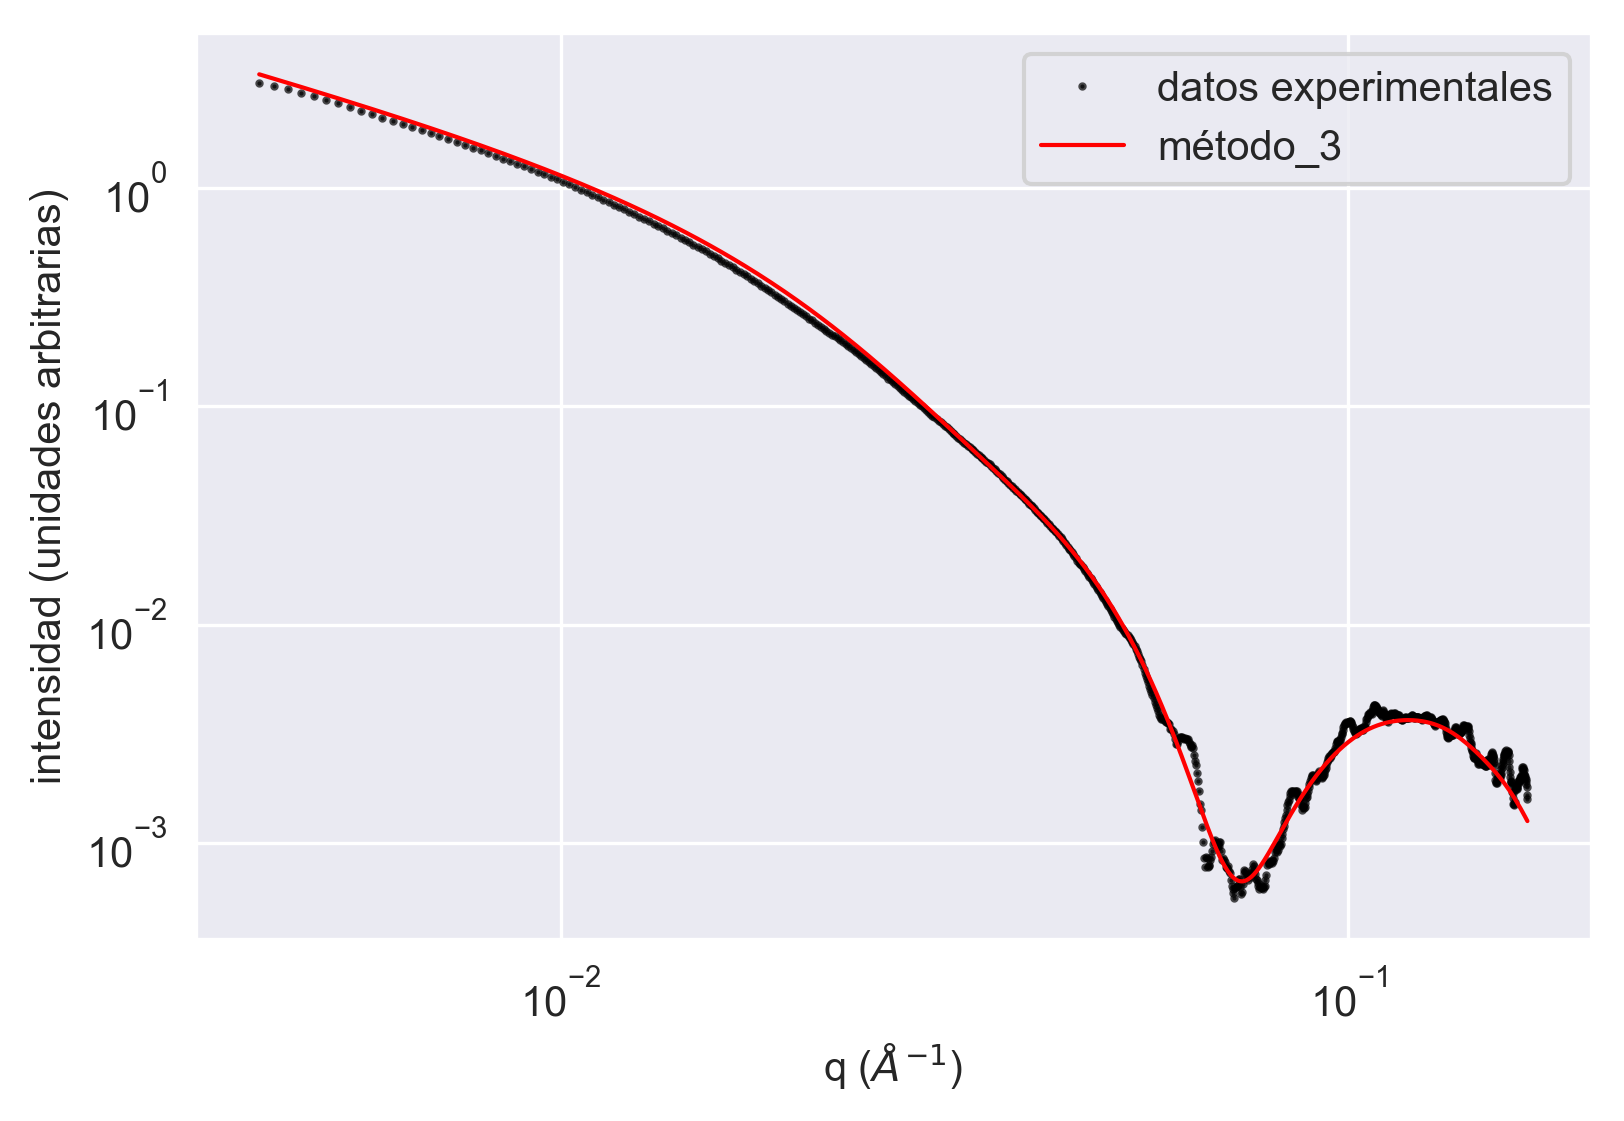

<Figure size 432x288 with 0 Axes>

In [61]:
plt.figure(dpi=300)

#funciones_base_evaluadas_1, funciones_base_no_nulas_1 = calcular_funciones_base(info_metodos[metodo_a_comparar_1]["p_no_l_optimo"], x_exp)
#y_modelo_1 = np.dot(funciones_base_evaluadas_1, info_metodos[metodo_a_comparar_1]["p_l_optimo"])

#funciones_base_evaluadas_2, funciones_base_no_nulas_2 = calcular_funciones_base(info_metodos[metodo_a_comparar_2]["p_no_l_optimo"], x_exp)
#y_modelo_2 = np.dot(funciones_base_evaluadas_2, info_metodos[metodo_a_comparar_2]["p_l_optimo"])

funciones_base_evaluadas_3, funciones_base_no_nulas_3 = calcular_funciones_base(info_metodos[metodo]["p_no_l_optimo"], x_exp)
y_modelo_3 = np.dot(funciones_base_evaluadas_3, info_metodos[metodo]["p_l_optimo"])

funciones_base_evaluadas_original, funciones_base_no_nulas_original = calcular_funciones_base(p_no_lineales_original, x_exp)
y_modelo_original = np.dot(funciones_base_evaluadas_original, p_lineales_original)

plt.plot(x_exp, y_exp, 'o', alpha=.7, markersize=1, label="datos experimentales", color="k", lw=.5)
#plt.plot(x_exp, y_modelo_1, '-', alpha=.9, markersize=3, label=metodo_a_comparar_1, color="r", lw=.1)
#plt.plot(x_exp, y_modelo_2, '-', alpha=.9, markersize=3, label=metodo_a_comparar_2, color="y", lw=.5)
plt.plot(x_exp, y_modelo_3, '-', alpha=1, markersize=3, label="método_3", color="red", lw=1)

plt.xlabel('q ($\AA^{-1}$)')
plt.ylabel('intensidad (unidades arbitrarias)')
plt.yscale("log")
plt.xscale("log")
#plt.title("Comparación Modelos")
plt.legend()
plt.savefig("Fig_8.jpg", dpi=300)
plt.show()

plt.clf()

### Gráficos de la distribución de los parámetros óptimos encontrados en cada inicialización

Acá podemos hacer un subplot por cada parámetros, y normalizarlas las distribuciones para compararlas (restar la media y dividir por std)

C:\Users\f.costa\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


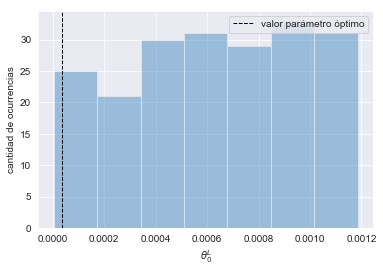

In [33]:
graficar_distribucion("p_l_0", r"$\theta^L_0$", "Fig_9_1")

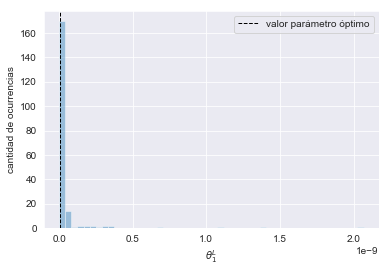

In [34]:
graficar_distribucion("p_l_1", r"$\theta^L_1$", "Fig_9_2")

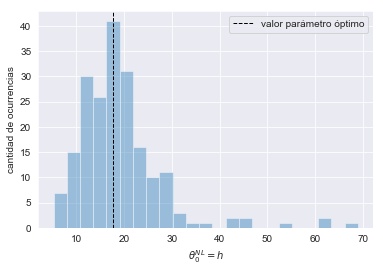

In [35]:
graficar_distribucion("p_no_l_0", r"$\theta^{NL}_0 = h$", "Fig_9_3")

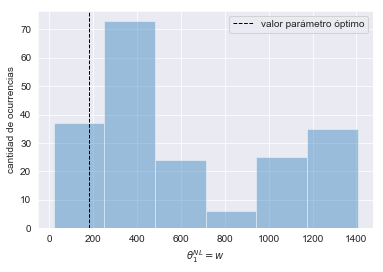

In [36]:
graficar_distribucion("p_no_l_1", r"$\theta^{NL}_1 = w$", "Fig_9_4")

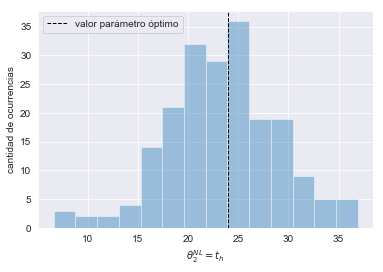

In [37]:
graficar_distribucion("p_no_l_2", r"$\theta^{NL}_2 = t_h$", "Fig_9_5")

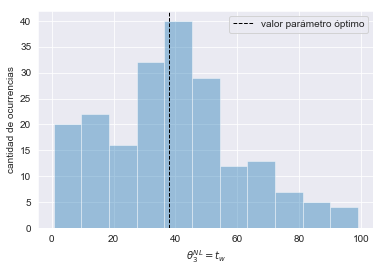

In [38]:
graficar_distribucion("p_no_l_3", r"$\theta^{NL}_3 = t_w$", "Fig_9_6")

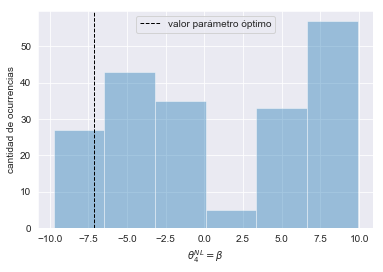

In [39]:
graficar_distribucion("p_no_l_4", r"$\theta^{NL}_4 = \beta$", "Fig_9_7")

### Correlaciones

In [55]:
porc_burn_in = .7

df_valores_parametros = pd.DataFrame()

#agrego la info de los parametros lineales
for num_p_l in range(len(p_lineales_original)):
    #parámetros optimos
    #historial_iteraciones = [item[1][num_p_l] for item in info_metodos[metodo]["info_debug"]]
    #parámetros búsqueda
    #historial_iteraciones = [item[4][num_p_l] for item in info_metodos[metodo]["info_debug"]]
    #parámetros new
    historial_iteraciones = [item[7][num_p_l] for item in info_metodos[metodo]["info_debug"]]
    
    #sacamos el primer item que es un -1 por defecto (estaria bueno cambiarlo a None en el codigo)
    historial_iteraciones = historial_iteraciones[1:]
    #sacamos las primeras iteraciones
    historial_iteraciones = historial_iteraciones[int(len(historial_iteraciones) * porc_burn_in) :-1]
    df_valores_parametros["p_l_" + str(num_p_l)] = historial_iteraciones

#agrego la info de los paramtros no lineales
for num_p_no_l in range(len(p_no_lineales_original)):
    #parámetros optimos
    #historial_iteraciones = [item[0][num_p_no_l] for item in info_metodos[metodo]["info_debug"]]
    #parámetros búsqueda
    #historial_iteraciones = [item[3][num_p_no_l] for item in info_metodos[metodo]["info_debug"]]
    #parámetros new
    historial_iteraciones = [item[6][num_p_no_l] for item in info_metodos[metodo]["info_debug"]]
    #sacamos el primer item que es un -1 por defecto (estaria bueno cambiarlo a None en el codigo)
    historial_iteraciones = historial_iteraciones[1:]
    historial_iteraciones = historial_iteraciones[int(len(historial_iteraciones) * porc_burn_in) :-1]
    df_valores_parametros["p_no_l_" + str(num_p_no_l)] = historial_iteraciones

#agrego la info de chi2
#chi2 búsqueda
#historial_iteraciones = [item[5] for item in info_metodos[metodo]["info_debug"]]
#chi2 new
historial_iteraciones = [item[8] for item in info_metodos[metodo]["info_debug"]]
#sacamos el primer item que es un -1 por defecto (estaria bueno cambiarlo a None en el codigo)
historial_iteraciones = historial_iteraciones[1:]
print("Tomaremos desde la iteración", int(len(historial_iteraciones) * porc_burn_in), "hasta el final.")
historial_iteraciones = historial_iteraciones[int(len(historial_iteraciones) * porc_burn_in) :-1]
print("En total son", len(historial_iteraciones), "iteraciones.")

#df_valores_parametros["chi_2"] = historial_iteraciones

df_corr_pearson = df_valores_parametros.corr(method = "pearson")
df_corr_spearman = df_valores_parametros.corr(method = "spearman")

Tomaremos desde la iteración 699 hasta el final.
En total son 299 iteraciones.


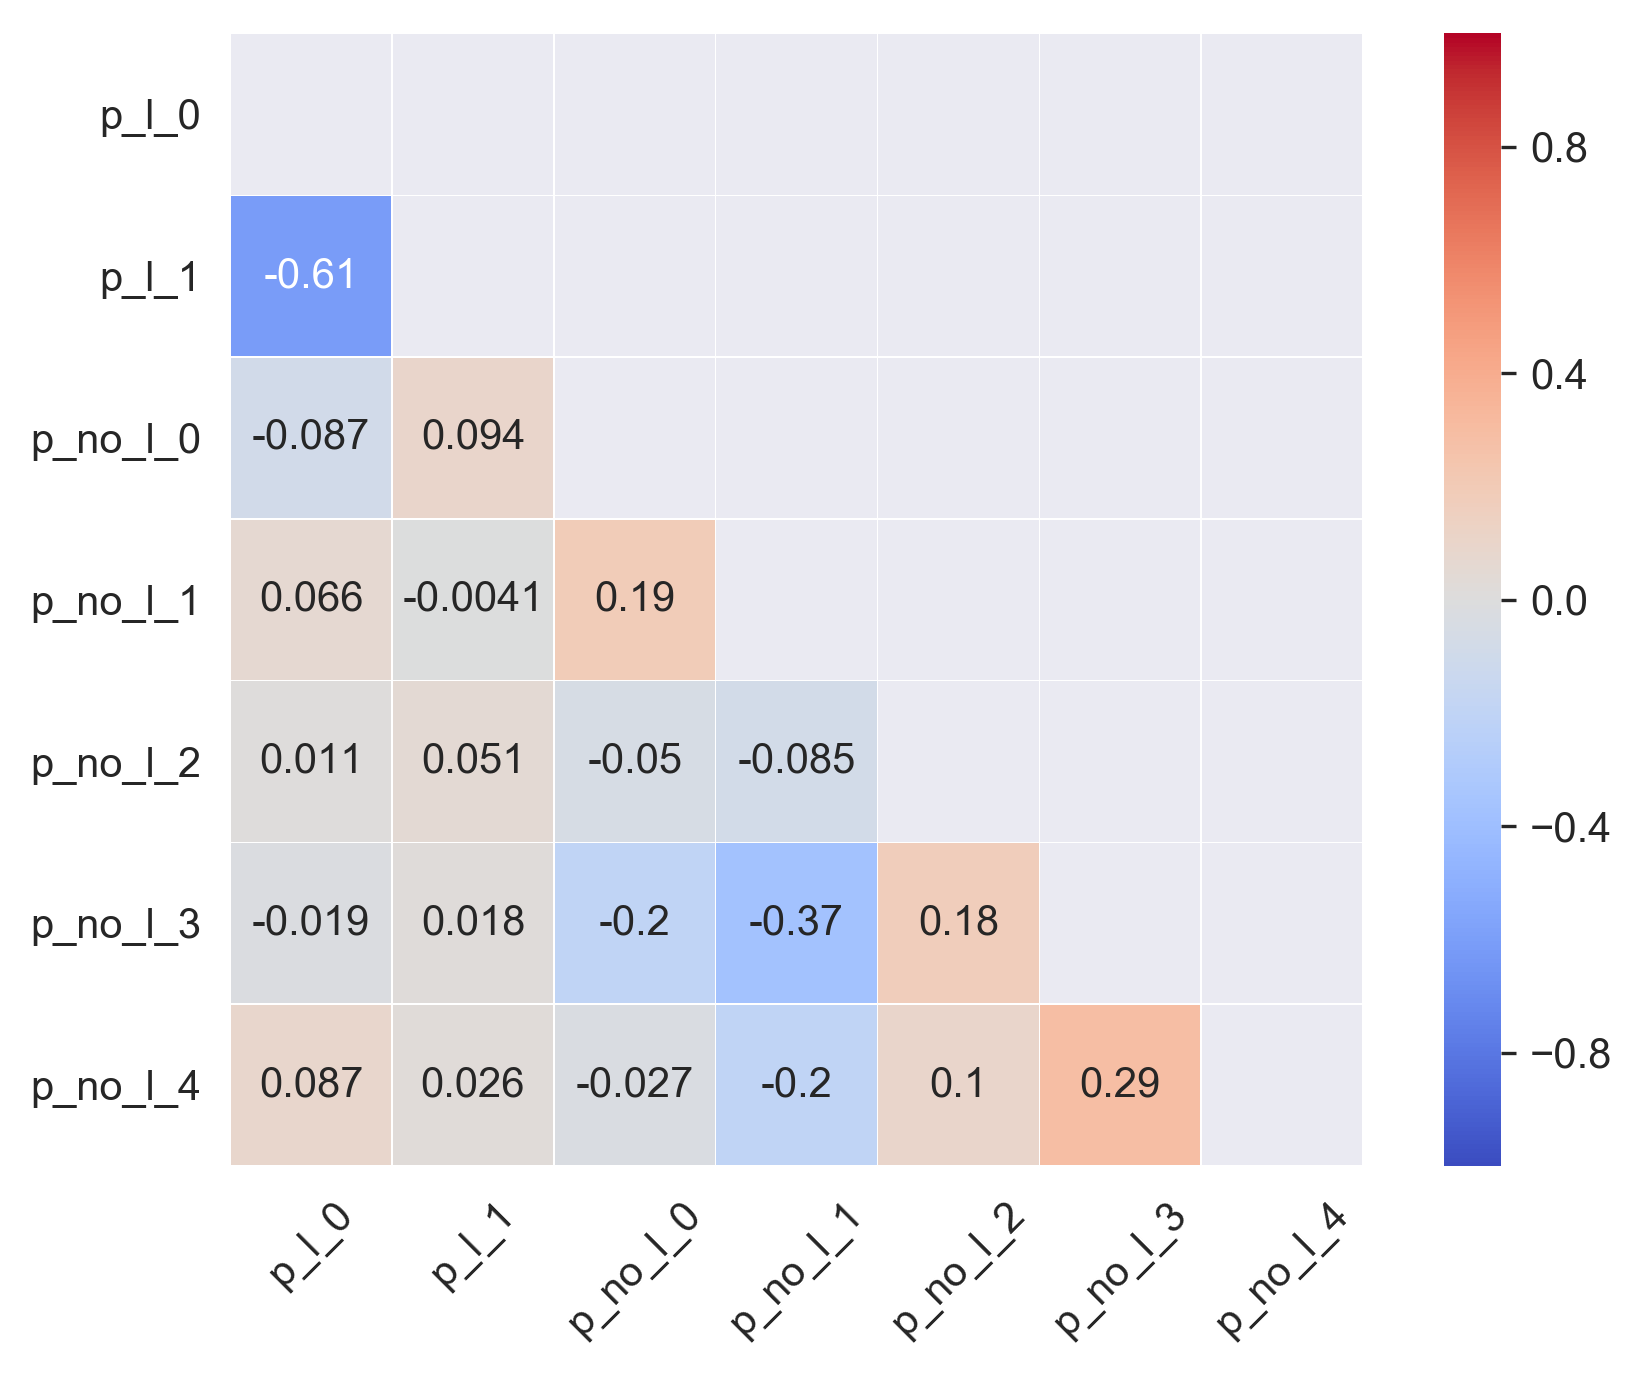

In [56]:
plt.figure(figsize = (7,5), dpi=300)
mask = np.zeros_like(df_corr_pearson)
mask[np.triu_indices_from(mask)] = True
sns.axes_style("white")
sns.heatmap(df_corr_pearson, 
                vmin=-1, vmax=1, cmap="coolwarm", 
                annot=True, linewidths=.1,
               square =True, mask = mask)
plt.yticks(rotation=0) 
plt.xticks(rotation=45) 
#plt.title("Correlaciones de Pearson")
plt.savefig("Fig_10.jpg", dpi = 300)
plt.show()

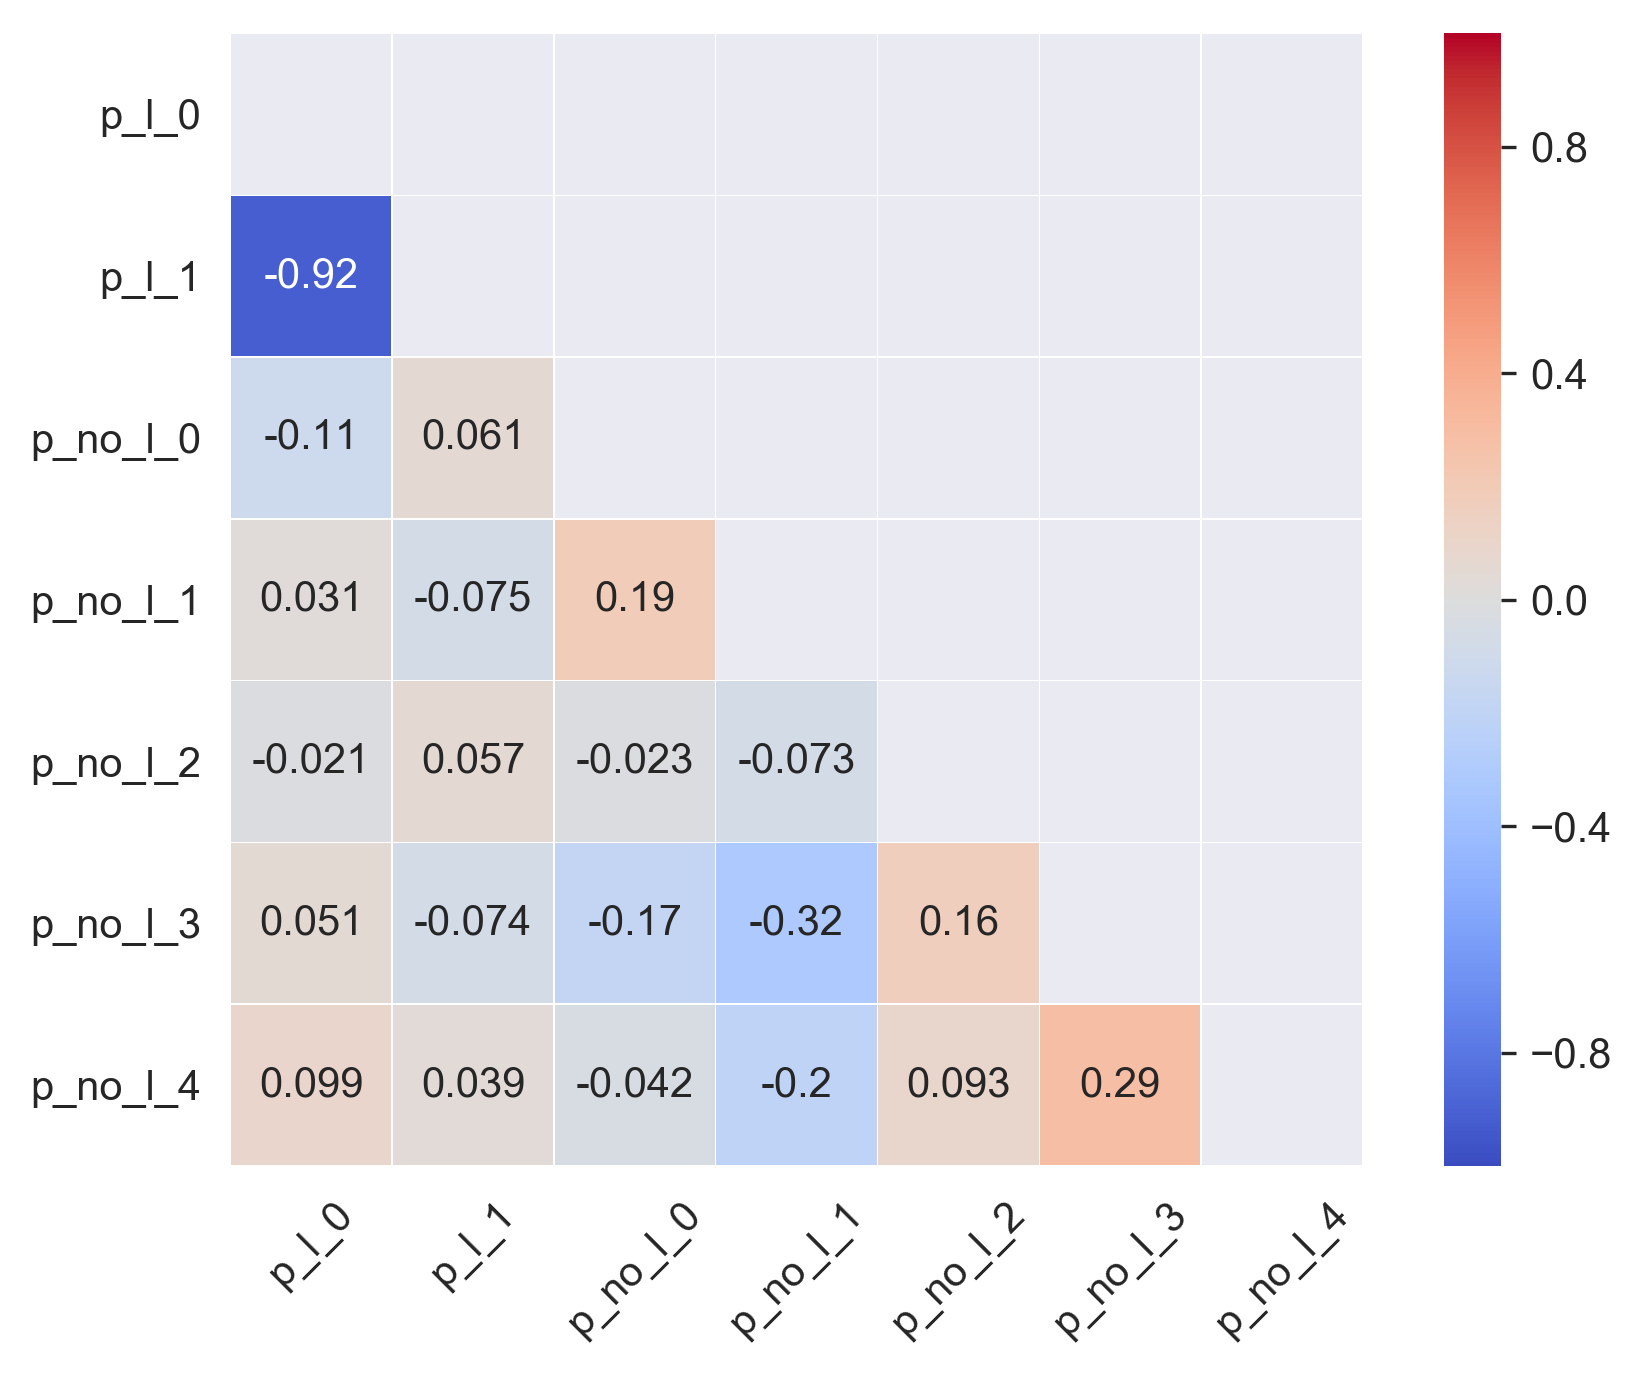

In [57]:
plt.figure(figsize = (7,5), dpi=300)
mask = np.zeros_like(df_corr_spearman)
mask[np.triu_indices_from(mask)] = True
sns.axes_style("white")
sns.heatmap(df_corr_spearman, 
                vmin=-1, vmax=1, cmap="coolwarm", 
                annot=True, linewidths=.1,
               square =True, mask = mask)
plt.yticks(rotation=0) 
plt.xticks(rotation=45)  
#plt.title("Correlaciones de Spearman")
plt.savefig("Fig_11.jpg", dpi = 300)
plt.show()

Este gráfico lo dejo comentado por las dudas, pero me pareció mejor el distplot vs el scatterplot por el tema de las distribuciones al costado

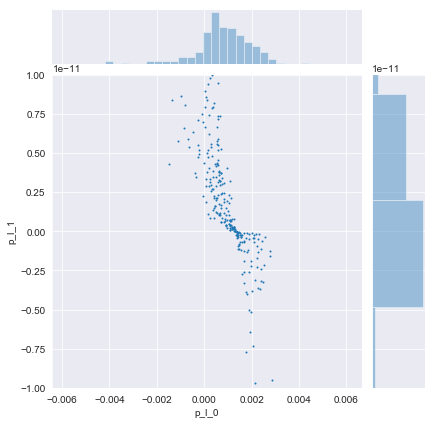

In [43]:
sns.jointplot(df_valores_parametros["p_l_0"], df_valores_parametros["p_l_1"], s = 1)
plt.ylim(-.00000000001, .00000000001)
plt.show()

## Análisis del método 3_1

In [44]:
metodo_a_comparar_1 = "metodo_3-1000_200"

#### Gráfico del comportamiento del valor de la función de costo para los parámetros óptimos

El primer valor menor o igual que 10 se da en la iteración: 523
El primer valor menor o igual que 1.5 se da en la iteración: 0


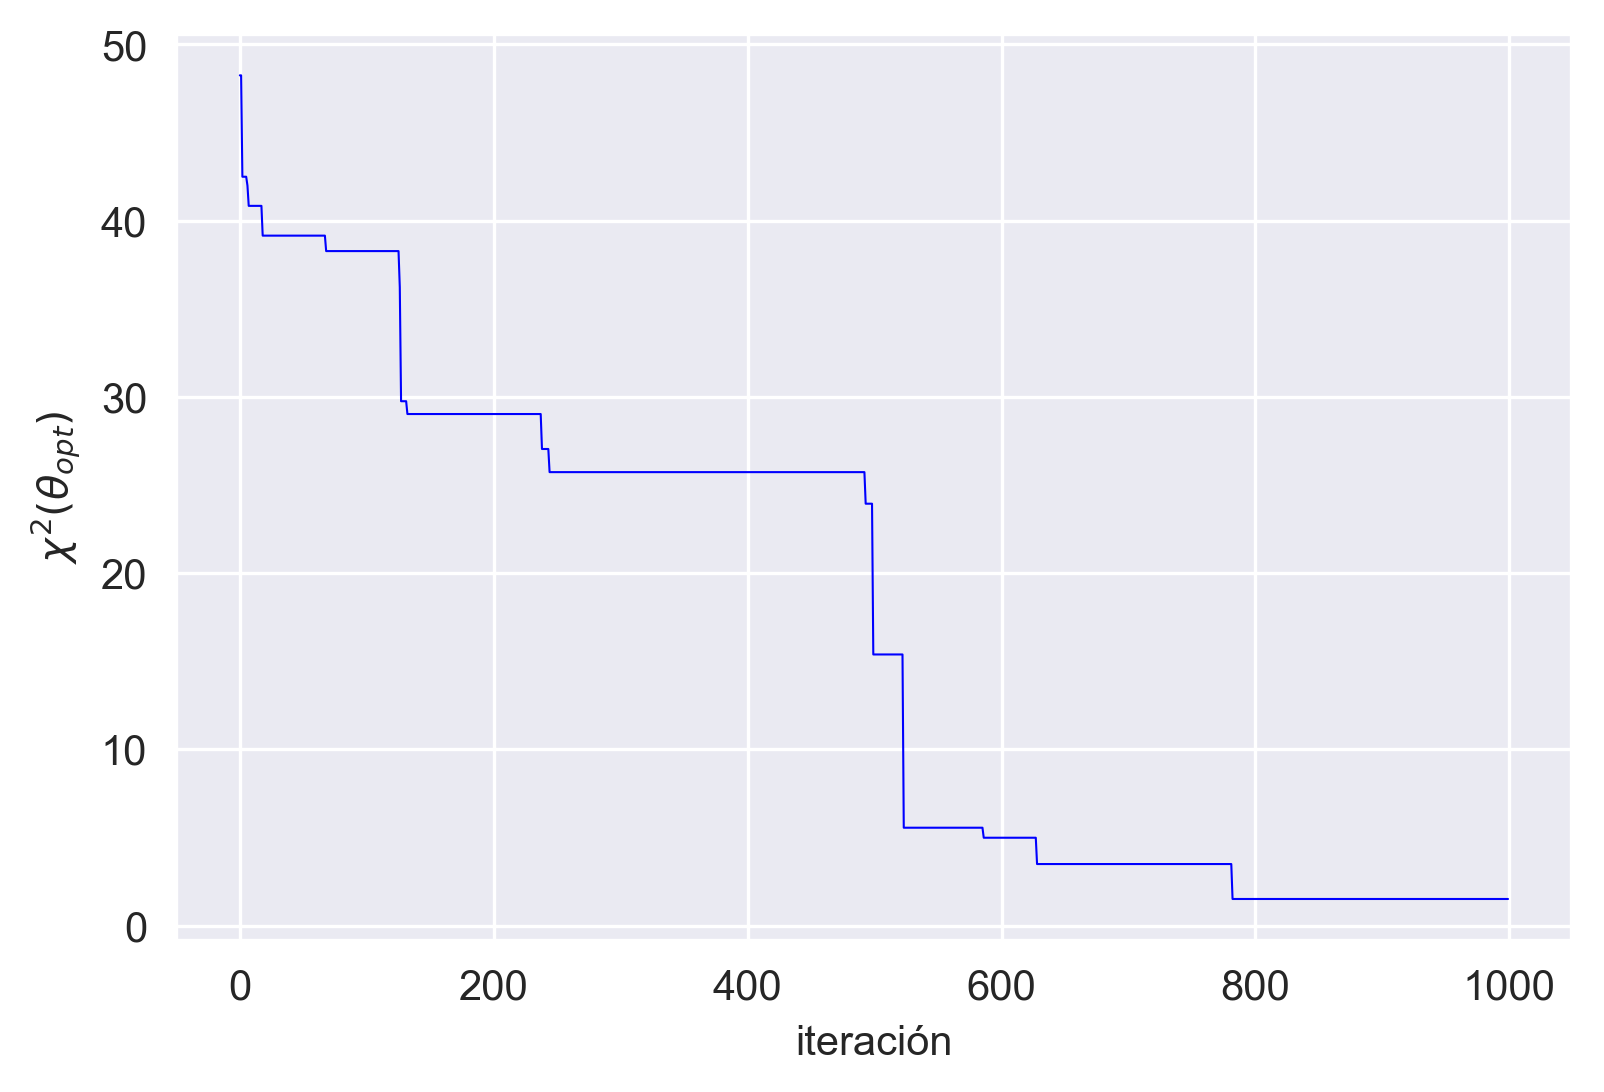

<Figure size 432x288 with 0 Axes>

In [45]:
plt.figure(dpi=300)

chi2_optimo = [item[2] for item in info_metodos[metodo_a_comparar_1]["info_debug"]]
#chi2_busqueda = [item[5] for item in info_metodos[metodo_a_comparar_1]["info_debug"]]

plt.plot(range(len(chi2_optimo)), chi2_optimo, '-', markersize = 1, lw = .5, color="b")
#plt.plot(range(len(chi2_busqueda)), chi2_busqueda, '-', markersize = .5, lw = .4, color="y", label = "búsqueda")

iteracion_buscada=0
contador = 0
for x in chi2_optimo:
    if x <= 10:
        iteracion_buscada = contador
        break
    contador = contador + 1
print("El primer valor menor o igual que 10 se da en la iteración:", iteracion_buscada)
    
iteracion_buscada=0
contador = 0
for x in chi2_optimo:
    if x <= 1.5:
        iteracion_buscada = contador
        break
    contador = contador + 1
print("El primer valor menor o igual que 1.5 se da en la iteración:", iteracion_buscada)

#plt.axhline(5, linestyle='--', alpha=.5, color="k", lw=.5)
#plt.yscale('log')
#extraticks = [0.1, 1, 5]
#plt.yticks(list(plt.yticks()[0]) + extraticks)
#plt.ylim([0, 2])
plt.xlabel('iteración')
plt.ylabel(r'$\chi^2(\theta _{opt})$')
#plt.title(r"Comportamiento de $\chi^2(\theta _{opt})$")
#plt.legend()
plt.savefig("Fig_12.jpg", dpi=300)
plt.show()

#limpiamos las variables para no ocupar memoria
chi2_metodo_1, chi2_metodo_1, chi2_metodo_3 = [], [], []
plt.clf()

#### Gráfico del comportamiento del valor de la función de costo para los parámetros búsqueda

Podemos ver cómo a veces el valor de la figura de mérito crece, producto de la lógica del simulated annealing. Es decir, a veces se aceptan parámetros (de búsqueda) aunque no hagan disminuir el valor de la figura de mérito.

Notemos que esta función de costo puede crecer porque está la posibilidad de aceptar esos cambios. De hecho cada vez que hay un escalón para arriba es porque se aceptó el cambio aunque el $\chi^2$ se más grande.

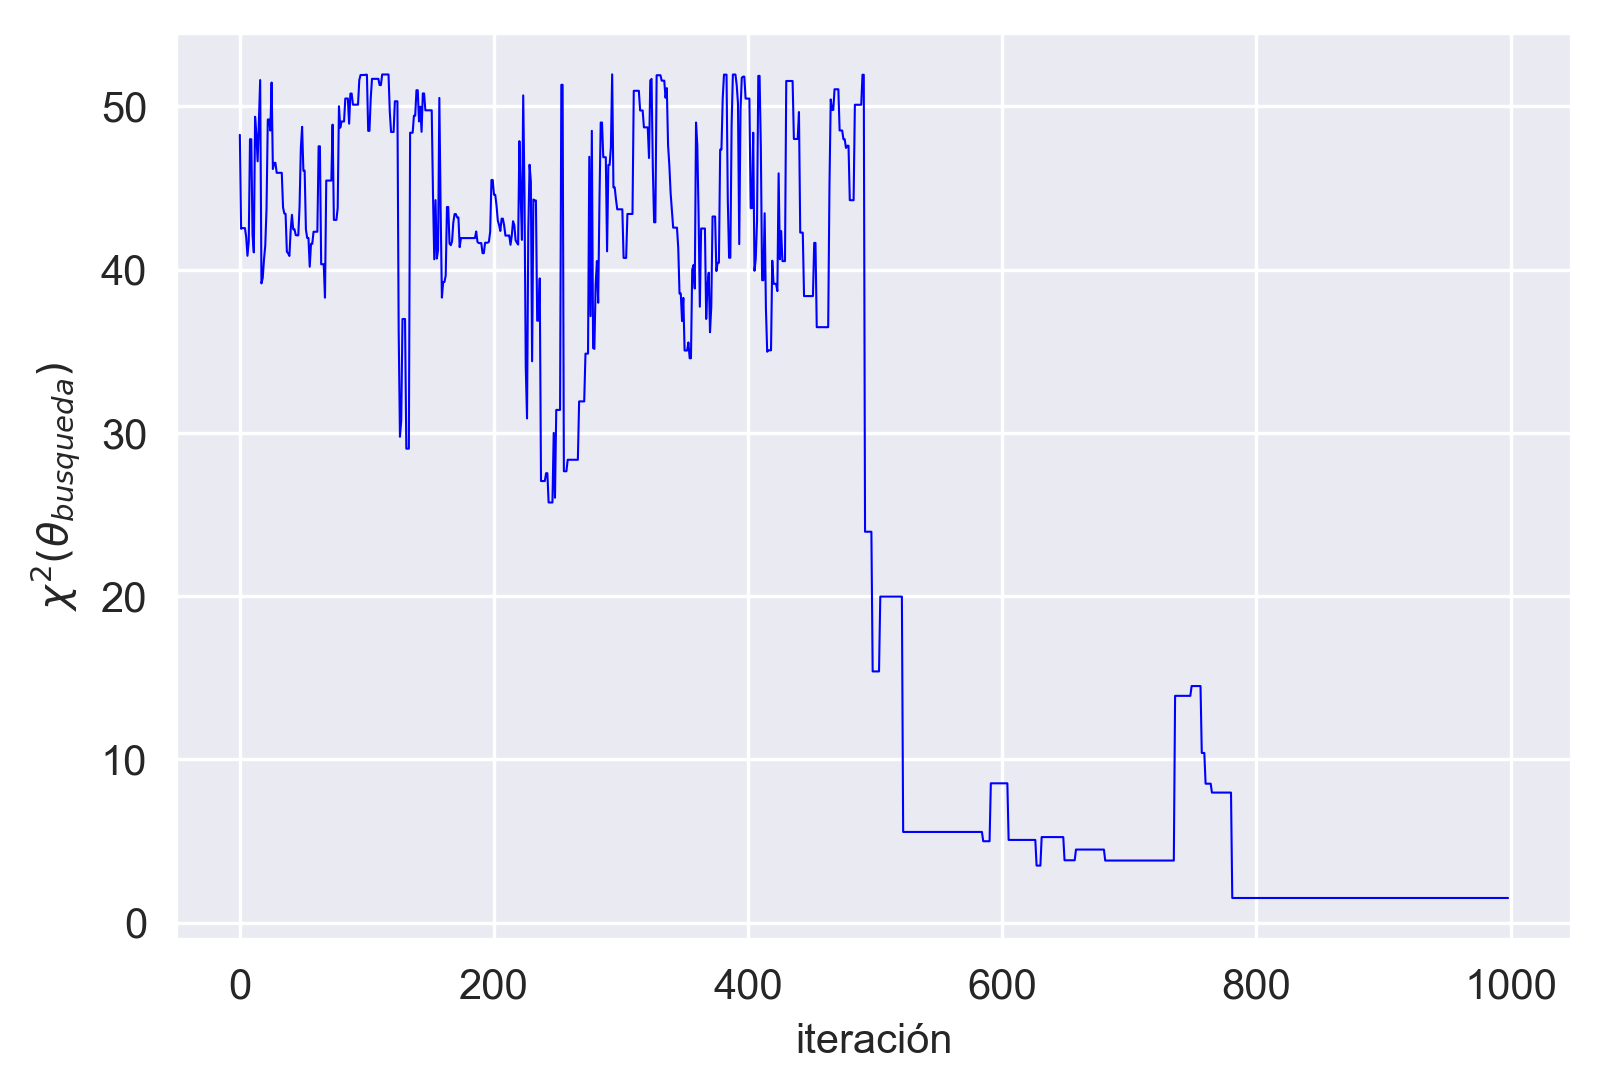

<Figure size 432x288 with 0 Axes>

In [46]:
plt.figure(dpi=300)

#chi2_optimo = [item[2] for item in info_metodos[metodo_a_comparar_1]["info_debug"]]
chi2_busqueda = [item[5] for item in info_metodos[metodo_a_comparar_1]["info_debug"]][1:]

#plt.plot(range(len(chi2_optimo)), chi2_optimo, '-', markersize = 1, lw = .5, color="b")
plt.plot(range(len(chi2_busqueda)), chi2_busqueda, '-', markersize = .3, lw = .5, color="b", label = "búsqueda")

#plt.axhline(5, linestyle='--', alpha=.5, color="k", lw=.5)
#plt.yscale('log')
#extraticks = [0.1, 1, 5]
#plt.yticks(list(plt.yticks()[0]) + extraticks)
#plt.ylim([0, 2])
plt.xlabel('iteración')
plt.ylabel(r'$\chi^2(\theta _{busqueda})$')
#plt.title(r"Comportamiento de $\chi^2(\theta _{opt})$")
#plt.legend()
plt.savefig("Fig_13.jpg", dpi=300)
plt.show()

#limpiamos las variables para no ocupar memoria
chi2_metodo_1, chi2_metodo_1, chi2_metodo_3 = [], [], []
plt.clf()

#### Gráfico del comportamiento de la temperatura

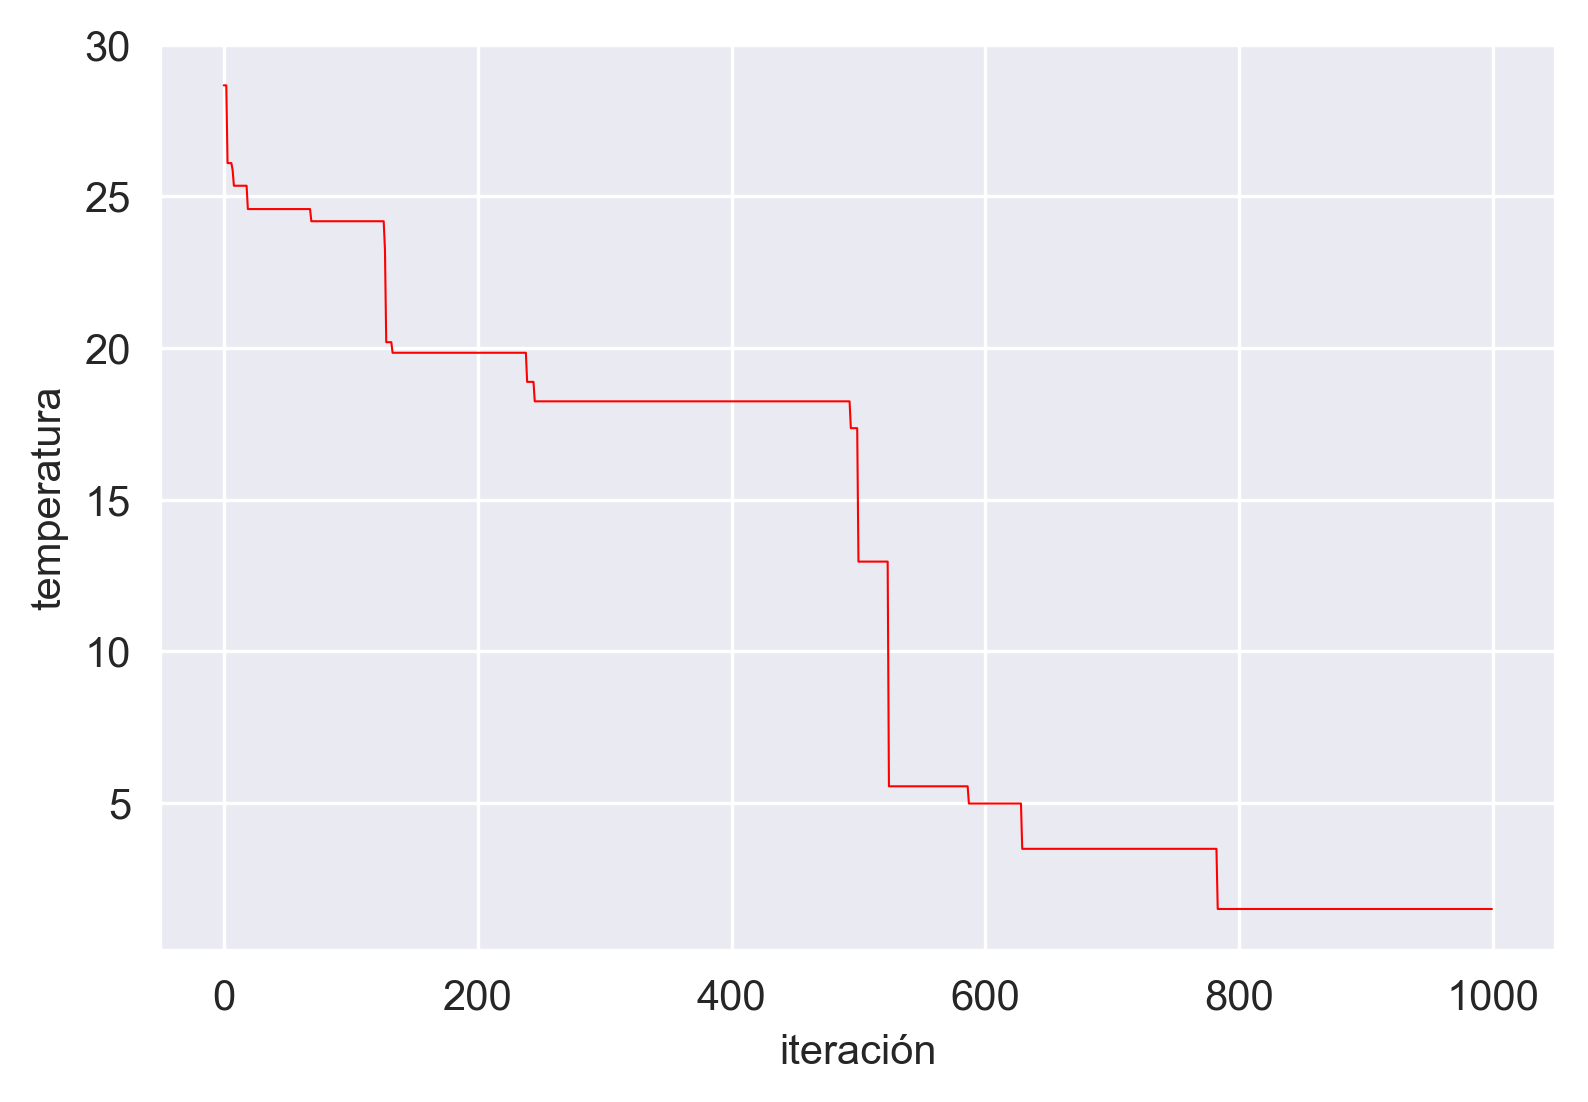

In [47]:
plt.figure(dpi=300)

temp_metodo_1 = [item[-1] for item in info_metodos[metodo_a_comparar_1]["info_debug"]]
#temp_metodo_2 = [item[-1] for item in info_metodos[metodo_a_comparar_2]["info_debug"]]
#temp_metodo_3 = [item[-1] for item in info_metodos[metodo_a_comparar_3]["info_debug"]]

iteracion_temp_10=0
contador = 0
for t in temp_metodo_1:
    if t <=10:
        iteracion_temp_10 = contador
        break
    contador = contador + 1


plt.plot(range(len(temp_metodo_1)), temp_metodo_1, '-', alpha=1, lw=.5, color="r")
#plt.plot(range(len(temp_metodo_2)), temp_metodo_2, '-', alpha=1, lw=.7, color="y", label = metodo_a_comparar_2)
#plt.plot(range(len(temp_metodo_3)), temp_metodo_3, '-', alpha=0.8, lw=.1, color="b")

#plt.axvline(iteracion_temp_10, linestyle = "--", color = "k", label = "temperatura = 10", lw=.5)

#extraticks = [contador]
#plt.xticks(list(plt.xticks()[0]) + extraticks)
#plt.xticks(np.arange(min(range(len(temp_metodo_1))), max(range(len(temp_metodo_1)))+1, 100))
#plt.ylim([0,2])
#plt.yscale('log')
plt.xlabel('iteración')
plt.ylabel('temperatura')
#plt.title("Comportamiento de la temperatura")
#plt.legend()
plt.savefig("Fig_14.jpg", dpi=300)
plt.show()

#limpiamos las variables para no ocupar memoria
temp_metodo_1, temp_metodo_2, temp_metodo_3 = [], [], []

#### Búsqueda de los parámetros no lineales óptimos comparada con el compartamiento de los parámetros óptimos

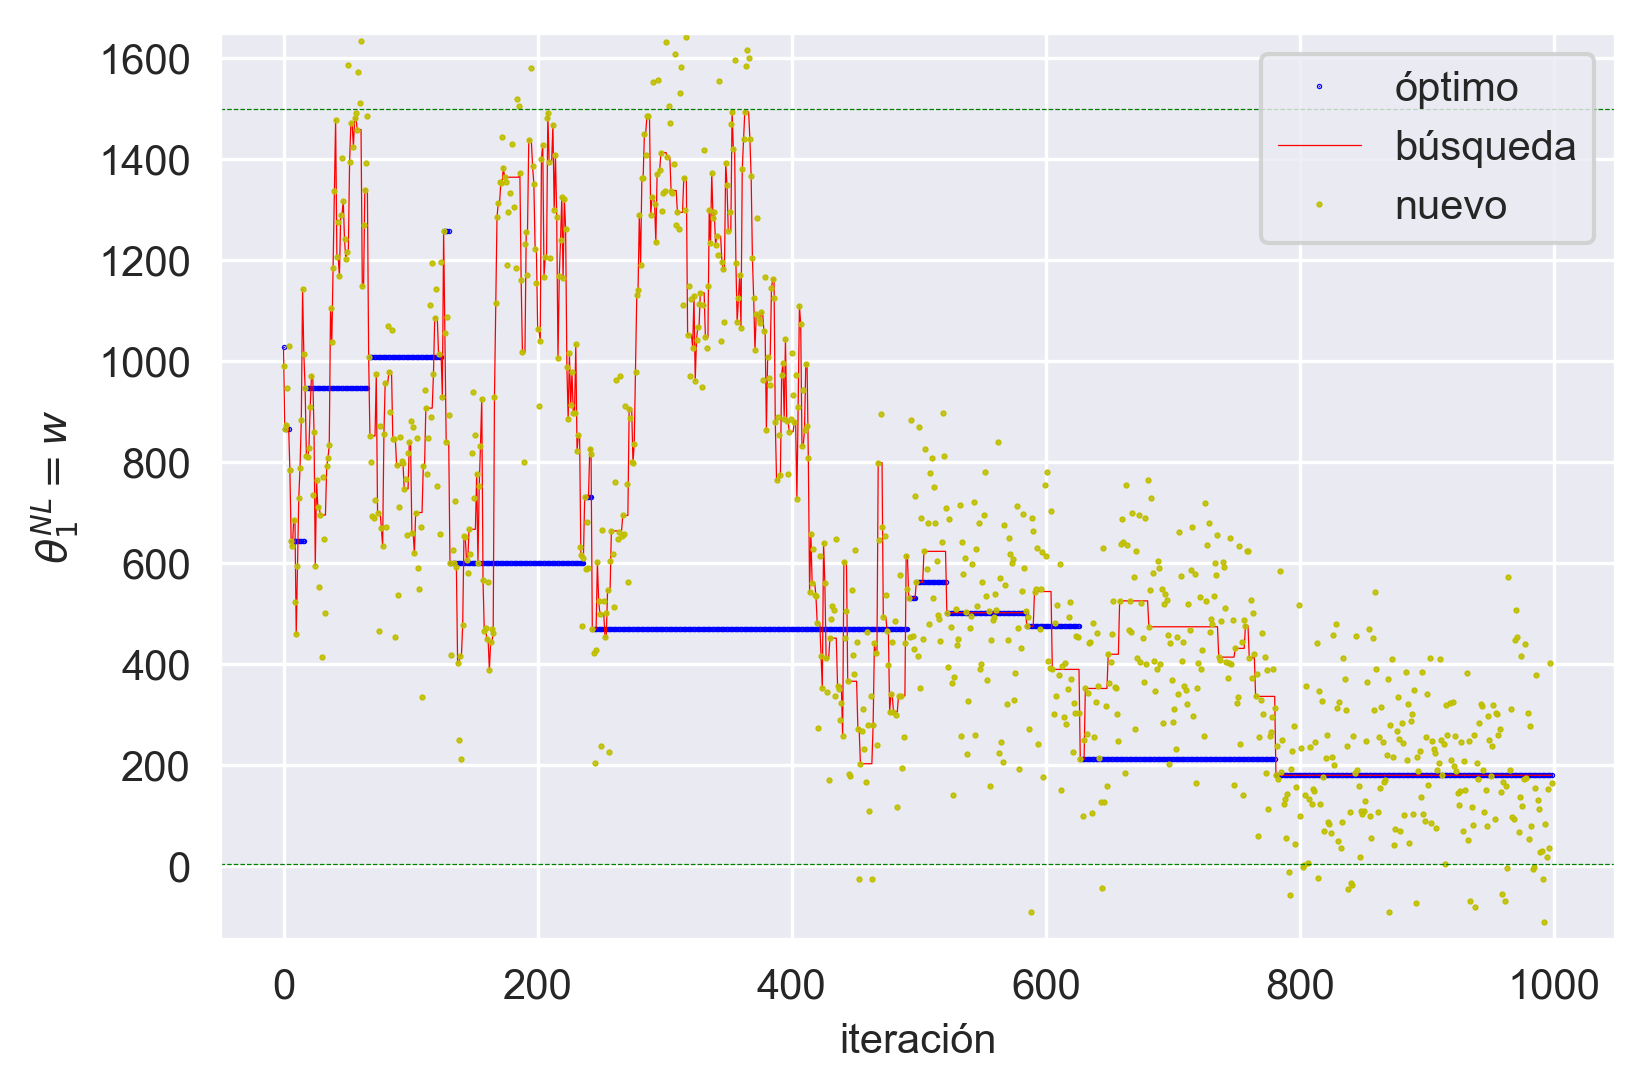

<Figure size 432x288 with 0 Axes>

In [58]:
plt.figure(dpi=300)

num_p_no_l = 1

p_no_lineal_optimo = [item[0][num_p_no_l] for item in info_metodos[metodo_a_comparar_1]["info_debug"]][1:]
p_no_lineal_busqueda = [item[3][num_p_no_l] for item in info_metodos[metodo_a_comparar_1]["info_debug"]][1:]
p_no_lineal_new = [item[6][num_p_no_l] for item in info_metodos[metodo_a_comparar_1]["info_debug"]][1:]

plt.plot(range(len(p_no_lineal_optimo)), p_no_lineal_optimo, 'o', alpha=1, markersize=.3, color="b", lw=.1, label = "óptimo")
plt.plot(range(len(p_no_lineal_busqueda)), p_no_lineal_busqueda, '-', alpha=1, markersize=.3, color="red", lw=.3, label = "búsqueda")
plt.plot(range(len(p_no_lineal_new)), p_no_lineal_new, 'o', alpha=1, markersize=.5, color="y", lw=.5, label = "nuevo")

long_rango = np.abs(rangos_p_no_lineales[num_p_no_l][1] - rangos_p_no_lineales[num_p_no_l][0])
plt.ylim(rangos_p_no_lineales[num_p_no_l] + np.multiply( (-1,1), long_rango * .1))
plt.axhline(rangos_p_no_lineales[num_p_no_l][0], linestyle="--", lw = .3, color = "g")
plt.axhline(rangos_p_no_lineales[num_p_no_l][1], linestyle="--", lw = .3, color = "g")
#plt.axvline(iteracion_temp_10, linestyle = "--", color = "k", label = "temperatura = 10", lw=.5)
#plt.xlim([0,200])
#plt.ylim([-10,100])
#plt.axhline(p_no_lineales_original[num_p_no_l], linestyle='--', color="k", lw=.5, label = "p no lineal original")
plt.xlabel('iteración')
plt.ylabel(r'$\theta^{NL}_1 = w$')
#plt.title("Búsqueda de los parámetros no lineales")
plt.legend()
plt.savefig("Fig_15.jpg", dpi=300)
plt.show()

#limpiamos las variables para no ocupar memoria
p_no_lineal_metodo_1, p_no_lineal_optimo_metodo_1 = [], []
plt.clf()

#### Comportamiento de alpha

In [49]:
iteracion_temp_10

524

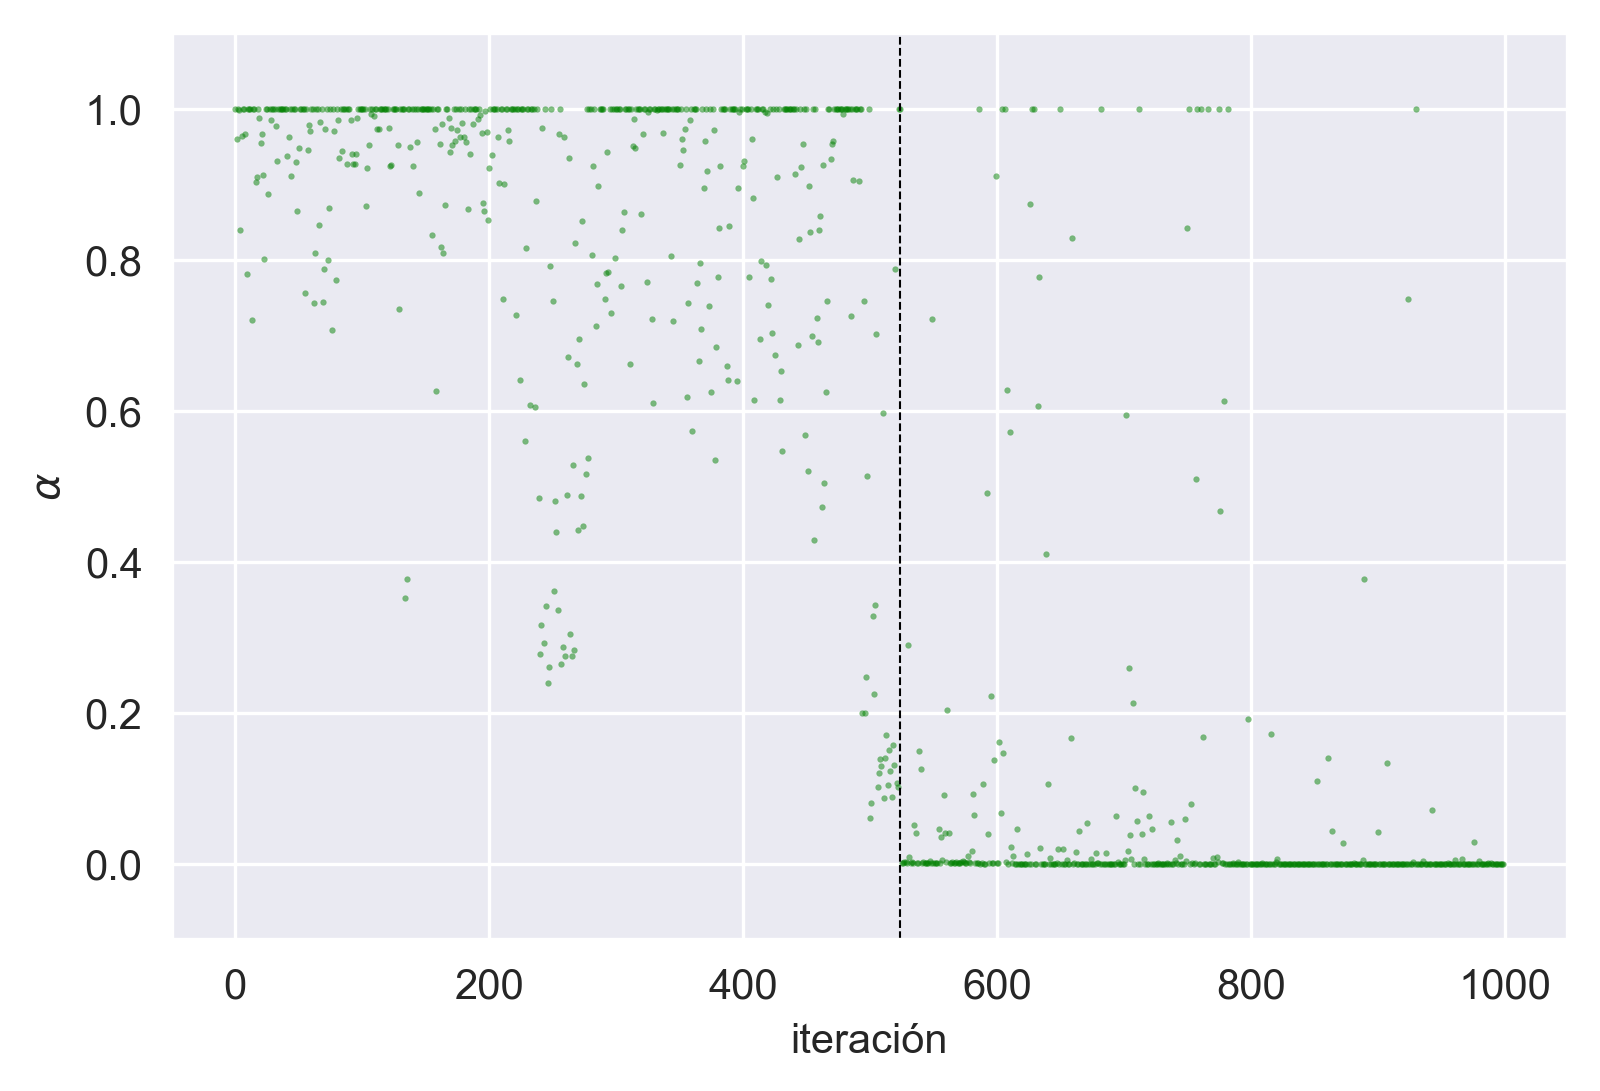

<Figure size 432x288 with 0 Axes>

In [50]:
plt.figure(dpi=300)

alphas_metodo_1 = [item[-2] for item in info_metodos[metodo_a_comparar_1]["info_debug"]]
#alphas_metodo_2 = [item[-2] for item in info_metodos[metodo_a_comparar_2]["info_debug"]]

plt.plot(range(len(alphas_metodo_1)), alphas_metodo_1, 'o', alpha=.5, markersize = .5, color="g")
#plt.plot(range(len(alphas_metodo_2)), alphas_metodo_2, 'o', alpha=.5, markersize = 2, color="g", label = metodo_a_comparar_2)
plt.axvline(iteracion_temp_10, linestyle = "--", color = "k", label = "temperatura = 10", lw=.5)
plt.ylim([-0.1,1.1])
#plt.yscale('log')
plt.xlabel('iteración')
plt.ylabel(r'$\alpha$')
#plt.title("Comportamiento de alpha")
#plt.legend()
plt.savefig("Fig_16.jpg", dpi=300)
plt.show()

alphas = []
plt.clf()

Vemos que cuando la temperatura baja de 10, la mayoría de los alphas se posicionan casi todos cerca del 0, es decir, es mucho menos probable aceptar un cambio que haga crecer el $\chi^2$ de búsqueda. Si se mira en la iteración en el gráfico del $\chi^2$ de búsqueda, cuando hay una crecida de la función, podemos ver en este gráfico el correspondiente alpha que corresponde con la probabilidad que había de aceptar el cambio que se dió.

Algo a remarcar con respecto a los alphas que me parece que podría llegar a andar mal de la manera que armamos el algoritmo: 


Cuando el sistema se va enfríando los alphas deberían ser casi todos 0 (y aceptar sólo cambios que bajen el $\chi^2$). Esto (si la última etapa de iteraciones se reinicia para buscar parámetros new desde los parámetros óptimos, cosa que hoy por hoy no hacemos ya que siempre se buscan los parámetros new desde los parámetros búsqueda) debería hacer que el método sampleé parámetros new cerca de los parámetros óptimos y que sólo acepte parámetros que mejoren el $\chi^2$, tratando de asegurar que los parámetros que encontramos son los mejores localmente.


Sin embargo, miremos cómo funciona en nuestra implementación: llegando al final de las iteraciones, el $\chi^2$ debería ser bastante cercano a 1, y recordando que $\alpha = \exp \lbrace{ \dfrac{\chi^2_{busqueda} - \chi^2_{new}}{T} \rbrace}$, tendríamos que $\alpha \approx \exp \lbrace{ \chi^2_{busqueda} - \chi^2_{new} \rbrace}$. Entonces si sampleamos parámetros new cercanos a los parámetros búsqueda, probablemente $\chi^2_{busqueda} < \chi^2_{new}$ pero sean valores muy cercanos (sobre todo si pensamos en ir reduciendo la $\sigma(temp)$ de la normal con la que sampleamos), haciendo que $\alpha$ pueda tomar valores grandes en la etapa de enfríamiento.

En nuestro caso tenemos un $\alpha > .6$ luego de la iteración 900 (y uno igual a 1, pero no cuenta porque ese porque se encontró un $\chi^2$ mejor).

In [51]:
alphas_metodo_1 = [item[-2] for item in info_metodos[metodo_a_comparar_1]["info_debug"]][1:]
iteraciones = range(len(alphas_metodo_1))
acumulada = [sum(alphas_metodo_1[:it]) for it in iteraciones]
temp_metodo_1 = [item[-1] for item in info_metodos[metodo_a_comparar_1]["info_debug"]]

In [52]:
#np.savetxt('nombre.dat', np.transpose(np.array([range(len(alphas_metodo_1)),alphas_metodo_1])))

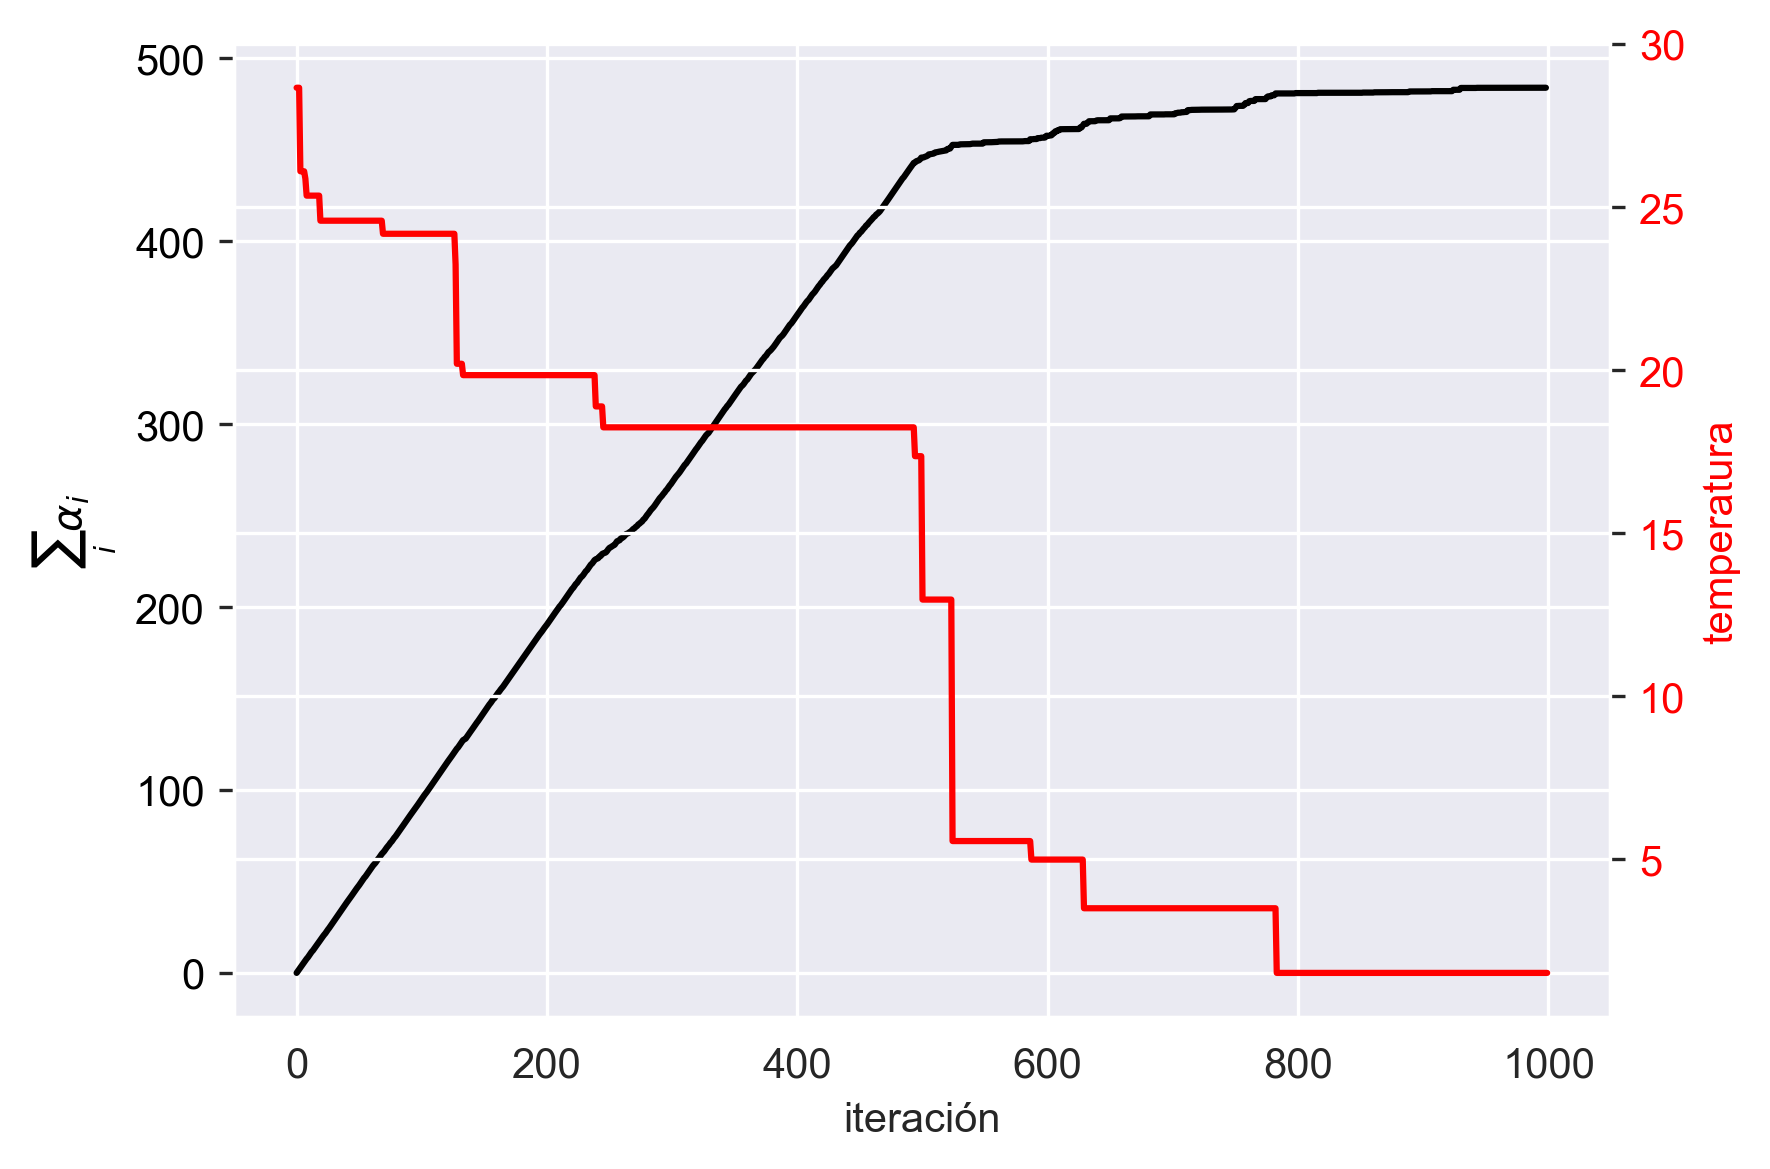

In [53]:
fig, ax1 = plt.subplots(dpi = 300)

color = "k"
ax1.set_xlabel('iteración')
ax1.set_ylabel(r'$\sum_{i} \alpha_i$', color=color)
ax1.plot(iteraciones, acumulada, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "r"
ax2.set_ylabel('temperatura', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(temp_metodo_1)), temp_metodo_1, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("Fig_20.jpg", dpi=300)
plt.show()

In [54]:
if False:
    temp_metodo_1 = [item[-1] for item in info_metodos[metodo_a_comparar_1]["info_debug"]]

    fig, ax1 = plt.subplots(dpi = 300)

    color = "g"
    ax1.set_xlabel('iteración')
    ax1.set_ylabel(r'$sum \alpha$', color=color)
    ax1.plot(range(len(alphas_metodo_1)), alphas_metodo_1, "o", color=color, alpha=.5, markersize = .5)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = "r"
    ax2.set_ylabel('temperatura', color=color)  # we already handled the x-label with ax1
    ax2.plot(range(len(temp_metodo_1)), temp_metodo_1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig("Fig_100.jpg", dpi=300)
    plt.show()